從目前整理好的ROLL數據中，挑出有包含選擇權策略的 (週選+月期)，全部都當作進場策略，回測4:00~5:00出現PCP數據時，多去買option

如果腳3是SC，就多BC
如果腳3是SP，就多BP

目前先暫時以與腳3相同履約價的商品為主

績效觀察：
1. 持有至隔天早上平倉 (8:45~8:55均價來計算)
2. 持有至到期日結算

延伸觀察點：
1. 選擇最靠近價平的商品
2. 選擇相較於pcp履約價更價外2檔的
3. 設定價外的屏障 (最多不能超過多少)

### 前處理
生成df_new來協助計算

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from datetime import datetime, timedelta
import re
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 在圖表上顯示中文
import matplotlib.ticker as mtick
from collections import Counter
import seaborn as sns

設定Future, Call, Put 的時間都需在4~5點之間

In [2]:
# **讀取 CSV**
df = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\PCP.csv', encoding='utf-8-sig')

# **設定時間範圍**
start_time = pd.to_datetime("04:00:00").time()
end_time = pd.to_datetime("05:00:00").time()

# **轉換時間格式**
df["FutMonthlyTime"] = pd.to_datetime(df["FutMonthlyTime"], errors="coerce")
df["CallTime"] = pd.to_datetime(df["CallTime"], errors="coerce")
df["PutTime"] = pd.to_datetime(df["PutTime"], errors="coerce")

# **篩選符合條件的數據**
df = df[
    (df["SourceType"] == "Option-Monthly") &
    (df["FutMonthlyTime"].dt.time >= start_time) & (df["FutMonthlyTime"].dt.time <= end_time) &
    (df["CallTime"].dt.time >= start_time) & (df["CallTime"].dt.time <= end_time) &
    (df["PutTime"].dt.time >= start_time) & (df["PutTime"].dt.time <= end_time)
]

# **排除不需要的欄位**
columns_to_remove = ["WeeklyFutTime", "WeeklyFutPrice", "WeeklyFutID", "WeeklyFutFee", "WeeklyFutBS"]
df = df.drop(columns=columns_to_remove, errors="ignore")  # 避免 KeyError

# **顯示篩選後的數據數量**
print(f"📌 篩選後剩餘的數據筆數：{df.shape[0]}")
df


📌 篩選後剩餘的數據筆數：1005


,TradeIndex_FutMonthly,TradeDate,SourceType,FutMonthlyTime,FutMonthlyPrice,FutMonthlyID,FutMonthlyFee,FutMonthlyBS,StrikePrice,CallTime,CallPrice,CallID,CallFee,CallBS,PutTime,PutPrice,PutID,PutFee,PutBS
664,666,2024/2/1,Option-Monthly,2024-02-01 04:05:00,17917.0,MXFB4,31.0,B,18600.0,2024-02-01 04:05:00,7.0,TX118600B4,11.0,S,2024-02-01 04:05:00,690.0,TX118600N4,45.000000,B
665,667,2024/2/1,Option-Monthly,2024-02-01 04:10:00,17910.0,MXFB4,31.0,B,18450.0,2024-02-01 04:10:00,14.5,TX118450B4,12.0,S,2024-02-01 04:10:00,550.0,TX118450N4,39.000000,B
666,668,2024/2/1,Option-Monthly,2024-02-01 04:10:00,17913.0,MXFB4,31.0,B,18450.0,2024-02-01 04:10:00,14.5,TX118450B4,12.0,S,2024-02-01 04:10:00,550.0,TX118450N4,39.000000,B
781,783,2024/2/23,Option-Monthly,2024-02-23 04:52:00,18994.0,MXFC4,32.0,S,18500.0,2024-02-23 04:52:00,500.0,TX418500B4,36.0,B,2024-02-23 04:52:00,6.4,TX418500N4,11.000000,S
1290,1292,2024/3/11,Option-Monthly,2024-03-09 04:46:00,19744.0,MXFC4,33.0,S,18850.0,2024-03-09 04:46:00,885.0,TX218850C4,55.0,B,2024-03-09 04:46:00,3.3,TX218850O4,11.000000,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20959,21131,2025/5/1,Option-Monthly,2025-05-01 05:00:00,20417.0,MXFE5,33.0,S,20900.0,2025-05-01 05:00:00,38.5,TX120900E5,13.0,B,2025-05-01 05:00:00,515.0,TX120900Q5,36.333333,S
20960,21132,2025/5/1,Option-Monthly,2025-05-01 05:00:00,20412.0,MXFE5,33.0,S,20900.0,2025-05-01 05:00:00,38.5,TX120900E5,13.0,B,2025-05-01 05:00:00,515.0,TX120900Q5,36.333333,S
20961,21133,2025/5/1,Option-Monthly,2025-05-01 05:00:00,20414.0,MXFE5,33.0,S,20900.0,2025-05-01 05:00:00,39.0,TX120900E5,13.0,B,2025-05-01 05:00:00,520.0,TX120900Q5,36.666667,S
20962,21134,2025/5/1,Option-Monthly,2025-05-01 05:00:00,20413.0,MXFE5,33.0,S,20900.0,2025-05-01 05:00:00,40.0,TX120900E5,13.0,B,2025-05-01 05:00:00,520.0,TX120900Q5,36.666667,S


設定與抓取選擇權腳3為SC、SP之策略

In [3]:
def analyze_pcp_with_bs(df_pcp):
    """
    進一步分析 PCP 數據，包含理論與實際價格比較以及交易腳判斷。
    """
    df_pcp = df_pcp.copy()
    strategy_type = []
    for _, row in df_pcp.iterrows():
        C = row['CallPrice']    # Call 價格
        P = row['PutPrice']     # Put 價格
        FutureBS = row['FutMonthlyBS']  # 買賣方向 (B/S)
        
        # 判斷策略類型
        if FutureBS == "B":
            # 理論大：Buy Future + Short Call + Long Put
            if C > P:
                strategy_type.append("BP") # Short Call 腳1, Long Put 腳3
            else:
                strategy_type.append("SC")   # Short Call 腳3, Long Put 腳1

        else:
            # 實際大：Sell Future + Long Call + Short Put
            if C > P:
                strategy_type.append("SP")   # Long Call 腳1, Short Put 腳3
            else:
                strategy_type.append("BC")   # Long Call 腳3, Short Put 腳1
        
    
    df_pcp["ArbitrageStrategy"] = strategy_type
    
    # 轉成 DataFrame
    df_results = pd.DataFrame(df_pcp)
    return df_results


df_option_pcp = analyze_pcp_with_bs(df)

# 排除BC、BP資料，只觀察SC、SP資料
df_option_pcp = df_option_pcp[~df_option_pcp["ArbitrageStrategy"].isin(["BC", "BP"])]
df_option_pcp.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\PCP_option.csv',index = False, encoding = 'utf-8-sig')
df_option_pcp

,TradeIndex_FutMonthly,TradeDate,SourceType,FutMonthlyTime,FutMonthlyPrice,FutMonthlyID,FutMonthlyFee,FutMonthlyBS,StrikePrice,CallTime,CallPrice,CallID,CallFee,CallBS,PutTime,PutPrice,PutID,PutFee,PutBS,ArbitrageStrategy
664,666,2024/2/1,Option-Monthly,2024-02-01 04:05:00,17917.0,MXFB4,31.0,B,18600.0,2024-02-01 04:05:00,7.0,TX118600B4,11.0,S,2024-02-01 04:05:00,690.0,TX118600N4,45.0,B,SC
665,667,2024/2/1,Option-Monthly,2024-02-01 04:10:00,17910.0,MXFB4,31.0,B,18450.0,2024-02-01 04:10:00,14.5,TX118450B4,12.0,S,2024-02-01 04:10:00,550.0,TX118450N4,39.0,B,SC
666,668,2024/2/1,Option-Monthly,2024-02-01 04:10:00,17913.0,MXFB4,31.0,B,18450.0,2024-02-01 04:10:00,14.5,TX118450B4,12.0,S,2024-02-01 04:10:00,550.0,TX118450N4,39.0,B,SC
781,783,2024/2/23,Option-Monthly,2024-02-23 04:52:00,18994.0,MXFC4,32.0,S,18500.0,2024-02-23 04:52:00,500.0,TX418500B4,36.0,B,2024-02-23 04:52:00,6.4,TX418500N4,11.0,S,SP
1290,1292,2024/3/11,Option-Monthly,2024-03-09 04:46:00,19744.0,MXFC4,33.0,S,18850.0,2024-03-09 04:46:00,885.0,TX218850C4,55.0,B,2024-03-09 04:46:00,3.3,TX218850O4,11.0,S,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20948,21120,2025/5/1,Option-Monthly,2025-05-01 04:23:00,20328.0,MXFE5,33.0,S,19600.0,2025-05-01 04:23:00,800.0,TX119600E5,51.0,B,2025-05-01 04:23:00,67.0,TX119600Q5,14.0,S,SP
20949,21121,2025/5/1,Option-Monthly,2025-05-01 04:23:00,20330.0,MXFE5,33.0,S,19600.0,2025-05-01 04:23:00,800.0,TX119600E5,51.0,B,2025-05-01 04:23:00,65.0,TX119600Q5,14.0,S,SP
20952,21124,2025/5/1,Option-Monthly,2025-05-01 04:55:00,20397.0,MXFE5,33.0,S,19600.0,2025-05-01 04:55:00,855.0,TX119600E5,54.0,B,2025-05-01 04:55:00,54.0,TX119600Q5,14.0,S,SP
20953,21125,2025/5/1,Option-Monthly,2025-05-01 04:55:00,20380.0,MXFE5,33.0,B,21000.0,2025-05-01 04:55:00,23.5,TX121000E5,12.0,S,2025-05-01 04:55:00,645.0,TX121000Q5,43.0,B,SC


重新製作一個df_new，儲存重要資訊

將SC、SP策略合併，轉換成用Category來區分C or P

In [4]:
# **建立新的 DataFrame**
df_new = df_option_pcp.copy()

# **根據 `ArbitrageStrategy` 來選擇相應的欄位**
df_new["Time"] = df_new.apply(lambda x: x["CallTime"] if x["ArbitrageStrategy"] == "SC" else x["PutTime"], axis=1)
df_new["Price"] = df_new.apply(lambda x: x["CallPrice"] if x["ArbitrageStrategy"] == "SC" else x["PutPrice"], axis=1)
df_new["ID"] = df_new.apply(lambda x: x["CallID"] if x["ArbitrageStrategy"] == "SC" else x["PutID"], axis=1)
df_new["Fee"] = df_new.apply(lambda x: x["CallFee"] if x["ArbitrageStrategy"] == "SC" else x["PutFee"], axis=1)
df_new["StrikePrice"] = df_new["StrikePrice"]  # 履約價保持不變
df_new["Category"] = df_new.apply(lambda x: "C" if x["ArbitrageStrategy"] == "SC" else "P", axis=1)
df_new["FutPrice"] = df_new["FutMonthlyPrice"]

# **選擇需要的欄位並重新排序**
columns_order = ["Time", "Category", "Price", "ID", "Fee", "StrikePrice", "FutPrice"]
df_new = df_new[columns_order]

# **轉換為標準日期格式**
df_new["Date"] = pd.to_datetime(df_new["Time"]).dt.strftime("%Y-%m-%d")

# 觀察數據中出現哪些日期
unique_dates = df_new["Date"].unique()
unique_dates 

array(['2024-02-01', '2024-02-23', '2024-03-09', '2024-03-13',
       '2024-04-17', '2024-06-26', '2024-07-24', '2024-07-30',
       '2024-08-01', '2024-08-02', '2024-08-03', '2024-08-07',
       '2024-08-08', '2024-08-09', '2024-08-10', '2024-08-29',
       '2024-08-31', '2024-09-04', '2024-09-07', '2024-09-12',
       '2024-09-17', '2024-09-19', '2024-09-20', '2024-09-24',
       '2024-09-27', '2024-10-02', '2024-10-09', '2024-10-12',
       '2024-10-18', '2024-10-19', '2024-10-22', '2024-10-30',
       '2024-10-31', '2024-11-06', '2024-11-12', '2024-11-13',
       '2024-11-20', '2024-11-21', '2024-11-23', '2024-12-04',
       '2024-12-06', '2024-12-10', '2024-12-19', '2024-12-20',
       '2024-12-26', '2024-12-28', '2025-01-08', '2025-01-15',
       '2025-01-18', '2025-01-21', '2025-02-04', '2025-02-05',
       '2025-02-08', '2025-02-22', '2025-02-25', '2025-02-27',
       '2025-02-28', '2025-03-04', '2025-03-05', '2025-03-06',
       '2025-03-08', '2025-03-11', '2025-03-12', '2025-

透過選擇權ID生成其到期月份

In [5]:
# **月份對應編碼**
call_code = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]
put_code = ["M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]

# **函數：根據 `ID` 解析年月與交易類型**
def parse_product_code(id_value):
    if pd.isna(id_value) or len(id_value) < 3:
        return None  # 確保數據有效

    year_code = id_value[-1]  # 取得最後一碼（年分）
    month_code = id_value[-2]  # 倒數第二碼（月份編碼）
    type_code = id_value[2]   # 第三碼（選擇權類別）

    # **解析年分**
    year_map = {"4": "2024", "5": "2025"}  # 可以擴展其他年份
    year = year_map.get(year_code, None)
    if not year:
        return None  # 未知年份則返回 `None`

    # **解析月份**
    if month_code in call_code:
        month = f"{call_code.index(month_code) + 1:02d}"  # 轉換為 "01" ~ "12"
    elif month_code in put_code:
        month = f"{put_code.index(month_code) + 1:02d}"
    else:
        return None  # 未知月份則返回 `None`

    # **解析選擇權類型**
    if type_code in ["1", "2", "4", "5"]:
        return f"{year}{month}W{type_code}"  # 週選（加上 `W+數字`）
    elif type_code == "O":
        return f"{year}{month}"  # 月選（不加 `W` 標記）

    return None  # 未知類型

# **應用函數**
df_new["ProductCode"] = df_new["ID"].apply(parse_product_code)

目前Greek缺少4/23以後之資料，故暫時刪除

In [6]:
# **刪除 `Date` 在 2025-04-24 之後的數據**
df_new = df_new[df_new["Date"] <= "2025-04-23"]

In [7]:
df_new.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\PCP_option.csv',index = False, encoding = 'utf-8-sig')

### 市場數據面
市場數據的部分，暫時使用Greek資料，等到高頻資料齊全再來轉換，不過大致上應該是雷同的

1. 找結算日之結算價，計算到期日之損益
2. 抓取8:45~8:55數據，計算平倉價格
3. 4點到5點選擇權市場數據 (策略2、3需要)

#### 找結算日之結算價，計算到期日之損益

透過df_new中的ProductCode去抓取相應在df_settlement中的契約月份
1. 新增第一個欄位為SettlementPrice，抓取df_settlement中的臺指選擇權
2. 新增第二個欄位為SettlementDate，抓取df_settlement中的SettlementDate

In [8]:
df_settlement = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\Settlement_Prcie.csv', encoding='utf-8-sig') 

# **轉換 `SettlementDate` 格式**
df_settlement["SettlementDate"] = pd.to_datetime(df_settlement["最後結算日"], format="%Y/%m/%d").dt.strftime("%Y-%m-%d")
df_settlement

,最後結算日,契約月份,臺指選擇權,SettlementDate
0,2025/5/21,202505,21848,2025-05-21
1,2025/5/14,202505W2,21751,2025-05-14
2,2025/5/7,202505W1,20466,2025-05-07
3,2025/4/30,202504W5,20211,2025-04-30
4,2025/4/23,202504W4,19583,2025-04-23
...,...,...,...,...
67,2024/1/31,202401W5,17896,2024-01-31
68,2024/1/24,202401W4,17873,2024-01-24
69,2024/1/17,202401,17168,2024-01-17
70,2024/1/10,202401W2,17481,2024-01-10


In [9]:
df_new_0 = df_new
# **合併 df_new 與 df_settlement**
df_new_0 = df_new_0.merge(
    df_settlement[["契約月份", "臺指選擇權", "SettlementDate"]], 
    left_on="ProductCode", 
    right_on="契約月份", 
    how="left"
)

# **重命名欄位**
df_new_0.rename(columns={"臺指選擇權": "SettlementPrice"}, inplace=True)

# **移除 `契約月份` 欄位**
df_new_0.drop(columns=["契約月份"], inplace=True)
# **轉換 `Time` 為 `HHMMSS` 整數格式**
df_new_0["DateTime"] = pd.to_datetime(df_new_0["Time"]).dt.strftime("%H%M%S").astype(int)

# **檢查結果**
print("📌 `SettlementPrice` 和 `SettlementDate` 匹配完成：")
print(df_new_0.head())
print(f"✅ 更新後數據量: {len(df_new_0)}")

df_new_0.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_new.csv',index = False, encoding = 'utf-8-sig')
df_new_0

📌 `SettlementPrice` 和 `SettlementDate` 匹配完成：
                 Time Category  Price          ID   Fee  StrikePrice  \
0 2024-02-01 04:05:00        C    7.0  TX118600B4  11.0      18600.0   
1 2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
2 2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
3 2024-02-23 04:52:00        P    6.4  TX418500N4  11.0      18500.0   
4 2024-03-09 04:46:00        P    3.3  TX218850O4  11.0      18850.0   

   FutPrice        Date ProductCode  SettlementPrice SettlementDate  DateTime  
0   17917.0  2024-02-01    202402W1            18632     2024-02-15     40500  
1   17910.0  2024-02-01    202402W1            18632     2024-02-15     41000  
2   17913.0  2024-02-01    202402W1            18632     2024-02-15     41000  
3   18994.0  2024-02-23    202402W4            18993     2024-02-29     45200  
4   19744.0  2024-03-09    202403W2            19931     2024-03-13     44600  
✅ 更新後數據量: 594


,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,SettlementDate,DateTime
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,2024-02-15,40500
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,2024-02-15,41000
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,2024-02-15,41000
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,2024-02-29,45200
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,2024-03-13,44600
...,...,...,...,...,...,...,...,...,...,...,...,...
589,2025-04-03 04:48:00,C,51.0,TX221450D5,14.0,21450.0,20884.0,2025-04-03,202504W2,17430,2025-04-09,44800
590,2025-04-03 04:48:00,C,33.0,TX221450D5,13.0,21450.0,20868.0,2025-04-03,202504W2,17430,2025-04-09,44800
591,2025-04-03 04:49:00,C,62.0,TX221600D5,14.0,21600.0,20827.0,2025-04-03,202504W2,17430,2025-04-09,44900
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,2025-04-23,41500


#### 抓取8:45~8:55數據，計算平倉價格

In [ ]:
# **讀取 CSV 檔案**
df_tick_2024 = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\tick_2024_0845_0900.csv', encoding='utf-8-sig')
df_tick_2025 = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\tick_2025_0845_0900.csv', encoding='utf-8-sig')

# **合併數據**
df_tick = pd.concat([df_tick_2024, df_tick_2025], axis=0, ignore_index=True)
df_tick = df_tick[(df_tick["成交時間"] >= 84500) & (df_tick["成交時間"] <= 85500)]
df_tick.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_tick.csv',index = False, encoding = 'utf-8-sig')
df_tick

,成交日期,履約價格,到期月份(週別),買賣權別,成交時間,成交價格,成交數量(B or S),剩餘到期時間(秒),當下指數,IV,delta,gamma,vega,theta,rho
0,20240102,16900.0,202401,P,84500.0,17.5,1.0,1313999.0,17841.12782,0.175103,-0.060176,0.000187,4.348210,-2.552475,0.454324
1,20240102,17800.0,202401,P,84500.0,193.0,1.0,1313999.0,17841.12782,0.146865,-0.454260,0.000741,14.433095,-7.343764,3.454969
2,20240102,17000.0,202401,P,84500.0,22.0,120.0,1313999.0,17841.12782,0.169003,-0.075349,0.000231,5.173430,-2.936218,0.568908
3,20240102,16500.0,202401,P,84500.0,8.1,1.0,1313999.0,17841.12782,0.202836,-0.027132,0.000085,2.279272,-1.542189,0.204933
4,20240102,17300.0,202401,P,84500.0,48.0,1.0,1313999.0,17841.12782,0.154292,-0.154930,0.000424,8.675381,-4.527715,1.170927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8012440,20250423,19250.0,202505W1,C,84500.6,205.0,4.0,1227599.0,19349.00000,0.099114,0.619795,0.001006,14.537876,-5.603136,4.585480
8012441,20250423,19100.0,202505W1,C,84811.0,377.0,1.0,1227408.0,19349.00000,0.153225,0.678976,0.000612,13.669100,-7.948115,4.963216
8012442,20250423,19100.0,202505W1,C,84811.5,377.0,1.0,1227408.0,19349.00000,0.153225,0.678976,0.000612,13.669100,-7.948115,4.963216
8012443,20250423,20700.0,202505W1,C,85417.0,18.0,1.0,1227042.0,19349.00000,0.210123,0.055673,0.000140,4.286679,-3.219016,0.411861


#### 4點到5點選擇權市場數據 (策略2、3需要)

In [ ]:
# **讀取 CSV 檔案**
df_tick_2024_1 = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\tick_2024_0400_0500.csv', encoding='utf-8-sig')
df_tick_2025_1 = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\tick_2025_0400_0500.csv', encoding='utf-8-sig')

# **合併數據**
df_tick_1 = pd.concat([df_tick_2024_1, df_tick_2025_1], axis=0, ignore_index=True)
df_tick_1 = df_tick_1[(df_tick_1["成交時間"] >= 40000) & (df_tick_1["成交時間"] <= 50000)]
# **轉換 `df_tick` 的成交日期格式**
df_tick_1["TradeDate"] = pd.to_datetime(df_tick_1["成交日期"].astype(str), format="%Y%m%d").dt.strftime("%Y-%m-%d")
df_tick_1.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_tick_1.csv',index = False, encoding = 'utf-8-sig')
df_tick_1

,成交日期,履約價格,到期月份(週別),買賣權別,成交時間,成交價格,成交數量(B or S),剩餘到期時間(秒),當下指數,IV,delta,gamma,vega,theta,rho,TradeDate
0,20231230,18100.0,202401,C,40000.0,104.0,4.0,1590299.0,17828.012195,0.132429,0.320505,0.000675,14.326361,-5.407154,2.826597,2023-12-30
1,20231230,18100.0,202401,C,40000.2,104.0,4.0,1590299.0,17828.012195,0.132429,0.320505,0.000675,14.326361,-5.407154,2.826597,2023-12-30
2,20231230,18100.0,202401,C,40000.4,104.0,4.0,1590299.0,17828.012195,0.132429,0.320505,0.000675,14.326361,-5.407154,2.826597,2023-12-30
3,20231230,18100.0,202401,C,40000.6,104.0,4.0,1590299.0,17828.012195,0.132429,0.320505,0.000675,14.326361,-5.407154,2.826597,2023-12-30
4,20231230,17800.0,202401,C,40001.0,229.0,1.0,1590298.0,17828.500000,0.134548,0.538079,0.000737,15.899242,-6.234061,4.718128,2023-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700949,20250423,20300.0,202504W5,C,45946.5,13.5,1.0,636313.0,19141.000000,0.247322,0.049846,0.000153,2.797302,-4.739438,0.189726,2025-04-23
1700950,20250423,19000.0,202504W5,C,45954.0,380.0,1.0,636305.0,19141.000000,0.281743,0.584366,0.000509,10.603404,-20.770564,2.179455,2025-04-23
1700951,20250423,19400.0,202504W5,C,45954.0,165.0,1.0,636305.0,19141.000000,0.252216,0.363939,0.000548,10.209732,-17.789944,1.371809,2025-04-23
1700952,20250423,19000.0,202504W5,C,45954.5,380.0,1.0,636305.0,19141.000000,0.281743,0.584366,0.000509,10.603404,-20.770564,2.179455,2025-04-23


## 三種策略觀察
1. 直接挑腳3之反向操作
2. 選擇價平的 (看當前期貨價格在哪，選擇靠近它的)
3. 選擇比PCP履約價更價外2檔的

PCP數據當作交易信號，判別腳3為SC or SP，來去做BC or BP的操作，三者只差在購買之選擇權履約價不同

損益計算：
1. 買進選擇權後，持有至隔天上午平倉 (使用8:45~8:55之平均價格)
2. 買進選擇權後，持有至結算日結算

In [12]:
df_new_0 = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_new.csv', encoding = 'utf-8-sig')
df_new_1 = df_new_0.copy()
df_new_2 = df_new_0.copy()
df_new_3 = df_new_0.copy()

要針對df_new每一筆PCP去找，先對好日期，再針對日期下相同履約價、相同買賣權別、相同到期日之商品的欄位數據去平均，抓出新的價格放回df_new，欄位名稱為NewPrice

In [78]:
def calculate_new_price(df_tick, df_new, strike_price_col):
    """
    根據 `df_tick` 尋找匹配的 `NewPrice`，並更新 `NewDate`、`NumMatchingTrades`
    
    參數：
    df_tick: 選擇權交易數據 DataFrame
    df_new: PCP 計算數據 DataFrame
    strike_price_col: 需要匹配的履約價欄位 (可傳 'StrikePrice', 'AtTheMoneyStrikePrice', 'SelectedStrikePrice')
    
    回傳：
    更新後的 df_new DataFrame
    """
    # **轉換 `df_tick` 的成交日期格式**
    df_tick["TradeDate"] = pd.to_datetime(df_tick["成交日期"].astype(str), format="%Y%m%d").dt.strftime("%Y-%m-%d")

    # **初始化新欄位**
    df_new["NewPrice"] = None
    df_new["NewDate"] = None
    df_new["NumMatchingTrades"] = 0

    # **遍歷 `df_new`**
    for idx, row in df_new.iterrows():
        original_date = row["Date"]
        strike_price = row[strike_price_col]  # **動態使用不同策略的履約價**
        category = row["Category"]
        product_code = row["ProductCode"]

        # **尋找符合條件的 `df_tick` 數據**
        matching_tick = df_tick[
            (df_tick["TradeDate"] == original_date) &
            (df_tick["履約價格"] == strike_price) &
            (df_tick["買賣權別"] == category) &
            (df_tick["到期月份(週別)"] == product_code)
        ]

        # **如果找到數據，直接更新 `NewDate`**
        if not matching_tick.empty:
            df_new.at[idx, "NewDate"] = original_date
        else:
            # **尋找下一個有效交易日**
            next_available_dates = sorted(df_tick["TradeDate"].unique())
            next_dates = [d for d in next_available_dates if d > original_date]
            next_date = next_dates[0] if next_dates else None

            # **如果找到新的交易日，更新篩選條件**
            if next_date:
                matching_tick = df_tick[
                    (df_tick["TradeDate"] == next_date) &
                    (df_tick["履約價格"] == strike_price) &
                    (df_tick["買賣權別"] == category) &
                    (df_tick["到期月份(週別)"] == product_code)
                ]
                df_new.at[idx, "NewDate"] = next_date
            else:
                df_new.at[idx, "NewDate"] = None

        # **計算平均價格 & 紀錄匹配交易筆數**
        if not matching_tick.empty:
            avg_price = matching_tick["成交價格"].mean()
            num_trades = matching_tick.shape[0]

            df_new.at[idx, "NewPrice"] = avg_price
            df_new.at[idx, "NumMatchingTrades"] = num_trades

    # **過濾掉 `NewPrice` 為 None 的數據**
    df_new = df_new.dropna(subset=["NewPrice"])

    # **回傳結果**
    return df_new


稅與手續費計算
1. 隔天平倉

稅：選擇權價格 * 0.001 * 50

手續費：10.8

兩者都需四捨五入計算

2. 持有至到期日

稅：期貨結算價 * 0.00002 * 50

手續費：10.8

兩者皆須四捨五入計算

In [79]:
def calculate_fees_settlement(SettlementPrice):
    """計算稅與手續費"""
    tax = np.round(SettlementPrice * 0.00002 * 50,0)  # **稅**
    fee = np.round(10.8,0)  # **固定手續費**
    return tax + fee

def calculate_fees(price):
    """計算稅與手續費"""
    tax = np.round(price * 0.001 * 50,0)  # **稅**
    fee = np.round(10.8,0)  # **固定手續費**
    return tax + fee


def calculate_pnl(df_new, strike_price_col, price_col):
    """
    計算策略的損益，包括：
    1. 提前平倉 (`PnL_Early_Close`)
    2. 持有至到期 (`PnL_Settlement`)

    參數：
    df_new: PCP 計算數據 DataFrame
    strike_price_col: 履約價欄位 (可傳 'StrikePrice', 'AtTheMoneyStrikePrice', 'SelectedStrikePrice')

    回傳：
    更新後的 df_new DataFrame
    """
    # **計算內在價值**
    df_new["Intrinsic_Value"] = df_new.apply(
        lambda row: max(row["SettlementPrice"] - row[strike_price_col], 0) if row["Category"] == "C"
        else max(row[strike_price_col] - row["SettlementPrice"], 0), axis=1
    )

    # **計算第一種損益（買入 → 賣出）**
    df_new["PnL_Early_Close"] = (
        df_new["NewPrice"] * 50 - calculate_fees(df_new["NewPrice"])  # **賣出收入**
        - df_new[price_col] * 50 - calculate_fees(df_new[price_col])  # **買入成本**
    )

    # **計算第二種損益（持有至到期 → 結算）**
    df_new["PnL_Settlement"] = (
        df_new["Intrinsic_Value"] * 50 - calculate_fees_settlement(df_new["SettlementPrice"])  # **結算收入**
        - df_new[price_col] * 50 - calculate_fees(df_new[price_col])  # **買入成本**
    )

    # **回傳結果**
    return df_new


In [80]:
def calculate_strategy_performance(df, profit_column):
    """
    計算策略績效，包括：
    - 累積損益 (`Total PnL`)
    - 勝率 (`Win Rate`)
    - 賺賠比 (`Profit/Loss Ratio`)
    - 平均損益 (`Avg PnL`)
    
    參數：
    df: 交易數據 DataFrame
    profit_column: 要計算的損益欄位 (如 'PnL_Early_Close' 或 'PnL_Settlement')
    
    回傳：
    [累積損益, 勝率, 賺賠比, 平均損益]
    """
    total_pnl = df[profit_column].sum()
    win_rate = (df[df[profit_column] > 0].shape[0]) / df.shape[0]
    avg_profit = df[df[profit_column] > 0][profit_column].mean()
    avg_loss = abs(df[df[profit_column] < 0][profit_column].mean())
    profit_loss_ratio = avg_profit / avg_loss if avg_loss > 0 else float("inf")
    avg_pnl = total_pnl / df.shape[0]

    return [total_pnl, round(win_rate * 100, 2), round(profit_loss_ratio, 2), round(avg_pnl, 2)]

def generate_performance_table(df_list, strategy_names):
    """
    生成策略績效表格
    
    參數：
    df_list: 包含不同策略 `df_new` 的列表
    strategy_names: 對應的策略名稱 (如 ['策略 1', '策略 2', '策略 3'])
    
    回傳：
    格式化的 DataFrame，包含所有策略績效
    """
    performance_data = {
        "指標": ["累積損益", "勝率 (%)", "賺賠比", "平均損益"]
    }

    for df, strategy in zip(df_list, strategy_names):
        performance_data[f"{strategy} - 提前平倉"] = calculate_strategy_performance(df, "PnL_Early_Close")
        performance_data[f"{strategy} - 持有至到期"] = calculate_strategy_performance(df, "PnL_Settlement")

    df_performance = pd.DataFrame(performance_data)

    # **表格美化並限制數字格式**
    df_performance_styled = df_performance.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:.2f}", subset=df_performance.columns[1:])

    return df_performance_styled

In [81]:
def calculate_mad_bounds(df, column, threshold=3):
    """使用中位數 + MAD 來判定極端值"""
    median = np.median(df[column])
    mad = np.median(np.abs(df[column] - median))  # 計算 MAD
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    return lower_bound, upper_bound

#def calculate_percentile_bounds(df, column):
    #lower_bound = df[column].quantile(0.02) 
    #upper_bound = df[column].quantile(0.98)  
    #return lower_bound, upper_bound

def detect_extreme_values(df, column):
    """定義極端值範圍，並確保數據類型為 float"""
    df = df.copy()  # **建立明確副本，避免修改切片**
    df.loc[:, column] = pd.to_numeric(df[column], errors="coerce")  # **確保數據為 float**
    
    lower_bound, upper_bound = calculate_mad_bounds(df, column, threshold=3)
    
    extreme_profit = df[df[column] > upper_bound]  # **極端獲利**
    extreme_loss = df[df[column] < lower_bound]  # **極端虧損**
    
    extreme_profit_sum = extreme_profit[column].sum() if not extreme_profit.empty else 0
    extreme_loss_sum = extreme_loss[column].sum() if not extreme_loss.empty else 0
    
    return lower_bound, upper_bound, extreme_profit.shape[0], extreme_loss.shape[0], extreme_profit_sum, extreme_loss_sum

def count_extreme_events(df, column):
    """計算極端事件發生次數"""
    _, _, extreme_profit, extreme_loss, _, _, = detect_extreme_values(df, column)
    return extreme_profit.shape[0], extreme_loss.shape[0]

def remove_extreme_values(df, column):
    """移除極端值"""
    lower_bound, upper_bound, _, _, _, _, = detect_extreme_values(df, column)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def generate_performance_summary(df_list, strategy_names):
    """
    生成策略績效表格（去除極端值後）
    
    參數：
    df_list: 包含不同策略的 DataFrame 列表
    strategy_names: 對應的策略名稱
    
    回傳：
    格式化的 DataFrame，包含所有策略績效
    """
    performance_data = {
        "指標": ["累積損益", "勝率 (%)", "賺賠比", "平均損益"]
    }

    for df, strategy in zip(df_list, strategy_names):
        filtered_early_close = remove_extreme_values(df, "PnL_Early_Close")
        filtered_settlement = remove_extreme_values(df, "PnL_Settlement")
        
        performance_data[f"{strategy} - 提前平倉"] = calculate_strategy_performance(filtered_early_close, "PnL_Early_Close")
        performance_data[f"{strategy} - 持有至到期"] = calculate_strategy_performance(filtered_settlement, "PnL_Settlement")

    df_performance = pd.DataFrame(performance_data)

    # **表格美化並限制數字格式**
    df_performance_styled = df_performance.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:.2f}", subset=df_performance.columns[1:])

    return df_performance_styled


def generate_extreme_profit_loss_summary(df_list, strategy_names):
    """分開計算累積極端獲利與累積極端虧損"""
    extreme_profit_data = {
        "指標": ["累積極端獲利", "極端獲利筆數", "平均極端獲利"]
    }
    
    extreme_loss_data = {
        "指標": ["累積極端虧損", "極端虧損筆數", "平均極端虧損"]
    }

    for df, strategy in zip(df_list, strategy_names):
        _, _, extreme_profit_count_early, extreme_loss_count_early, extreme_profit_sum_early, extreme_loss_sum_early = detect_extreme_values(df, "PnL_Early_Close")
        _, _, extreme_profit_count_settle, extreme_loss_count_settle, extreme_profit_sum_settle, extreme_loss_sum_settle = detect_extreme_values(df, "PnL_Settlement")

        extreme_profit_data[f"{strategy} - 提前平倉"] = [
            extreme_profit_sum_early,
            extreme_profit_count_early,
            extreme_profit_sum_early / extreme_profit_count_early if extreme_profit_count_early > 0 else 0
        ]

        extreme_profit_data[f"{strategy} - 持有至到期"] = [
            extreme_profit_sum_settle,
            extreme_profit_count_settle,
            extreme_profit_sum_settle / extreme_profit_count_settle if extreme_profit_count_settle > 0 else 0
        ]

        extreme_loss_data[f"{strategy} - 提前平倉"] = [
            extreme_loss_sum_early,
            extreme_loss_count_early,
            extreme_loss_sum_early / extreme_loss_count_early if extreme_loss_count_early > 0 else 0
        ]

        extreme_loss_data[f"{strategy} - 持有至到期"] = [
            extreme_loss_sum_settle,
            extreme_loss_count_settle,
            extreme_loss_sum_settle / extreme_loss_count_settle if extreme_loss_count_settle > 0 else 0
        ]

    df_extreme_profit_data = pd.DataFrame(extreme_profit_data)
    df_extreme_loss_data = pd.DataFrame(extreme_loss_data)
    
    # **表格美化並限制數字格式**
    df_extreme_profit_data_styled = df_extreme_profit_data.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:.2f}", subset=df_extreme_profit_data.columns[1:])

    df_extreme_loss_data_styled = df_extreme_loss_data.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:.2f}", subset=df_extreme_loss_data.columns[1:])

    return df_extreme_profit_data_styled, df_extreme_loss_data_styled


### 1. 直接挑腳3之反向進行操作：
直接用現有的腳3即可，因為履約價相同，如果是SC，就當作變成BC

In [82]:
# **確保 `成交時間` 為 `INT` 格式**
df_tick_1["成交時間"] = df_tick_1["成交時間"].astype(int)

# **初始化新欄位**
df_new_1["SameStrikePrice"] = None
df_new_1["Delta"] = None
df_new_1["Vega"] = None

# **遍歷 `df_new_1` 的每一筆 PCP**
for idx, row in df_new_1.iterrows():
    strike_price = row["StrikePrice"]  # **使用相同履約價**
    product_code = row["ProductCode"]
    category = row["Category"]
    date = row["Date"]
    time = row["DateTime"]

    # **篩選符合 `ProductCode`、`Category`、`TradeDate`、相同 `StrikePrice` 的 `df_tick_1`**
    filtered_tick = df_tick_1[
        (df_tick_1["到期月份(週別)"] == product_code) &
        (df_tick_1["買賣權別"] == category) &
        (df_tick_1["TradeDate"] == date) &
        (df_tick_1["履約價格"] == strike_price)  # **匹配相同履約價**
    ]

    # **篩選 5 分鐘內的 `成交時間`**
    time_window = filtered_tick[
        (filtered_tick["成交時間"] >= int(time) ) & 
        (filtered_tick["成交時間"] <= int(time) + 500)
    ]
    
    # **計算相同履約價合約的成交均價**
    if not time_window.empty:
        df_new_1.at[idx, "SameStrikePrice"] = time_window["成交價格"].mean()
        df_new_1.at[idx, "Delta"] = time_window["delta"].mean()
        df_new_1.at[idx, "Vega"] = time_window["vega"].mean()

# **檢查結果**
print("📌 `SameStrikePrice`、`Delta`、`Vega` 計算完成：")
print(df_new_1.head())
print(f"✅ 更新後數據量: {len(df_new_1)}")


📌 `SameStrikePrice`、`Delta`、`Vega` 計算完成：
                  Time Category  Price          ID   Fee  StrikePrice  \
0  2024-02-01 04:05:00        C    7.0  TX118600B4  11.0      18600.0   
1  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
2  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
3  2024-02-23 04:52:00        P    6.4  TX418500N4  11.0      18500.0   
4  2024-03-09 04:46:00        P    3.3  TX218850O4  11.0      18850.0   

   FutPrice        Date ProductCode  SettlementPrice  ... DateTime  \
0   17917.0  2024-02-01    202402W1            18632  ...    40500   
1   17910.0  2024-02-01    202402W1            18632  ...    41000   
2   17913.0  2024-02-01    202402W1            18632  ...    41000   
3   18994.0  2024-02-23    202402W4            18993  ...    45200   
4   19744.0  2024-03-09    202403W2            19931  ...    44600   

   SameStrikePrice     Delta      Vega   NewPrice     NewDate  \
0         5.783333  0.040502  3.09

In [83]:
df_new_1

,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,...,DateTime,SameStrikePrice,Delta,Vega,NewPrice,NewDate,NumMatchingTrades,Intrinsic_Value,PnL_Early_Close,PnL_Settlement
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,...,40500,5.783333,0.040502,3.092317,6.6,2024-02-01,24,32.0,18.214167,1269.544167
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,...,41000,15.072917,0.089756,5.76168,16.115702,2024-02-01,121,182.0,28.57986,8304.600521
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,...,41000,15.072917,0.089756,5.76168,16.115702,2024-02-01,121,182.0,28.57986,8304.600521
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,...,45200,6.14,-0.046538,2.442855,5.882589,2024-02-23,224,0.0,-35.471665,-348.307
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,...,44600,3.3,-0.019743,1.03441,3.82,2024-03-11,10,0.0,3.644,-207.165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2025-04-03 04:48:00,C,51.0,TX221450D5,14.0,21450.0,20884.0,2025-04-03,202504W2,17430,...,44800,61.8,0.190113,7.450182,6.498734,2025-04-07,79,0.0,-2790.478228,-3132.09
590,2025-04-03 04:48:00,C,33.0,TX221450D5,13.0,21450.0,20868.0,2025-04-03,202504W2,17430,...,44800,61.8,0.190113,7.450182,6.498734,2025-04-07,79,0.0,-2790.478228,-3132.09
591,2025-04-03 04:49:00,C,62.0,TX221600D5,14.0,21600.0,20827.0,2025-04-03,202504W2,17430,...,44900,61.515152,0.168625,6.947083,5.178641,2025-04-07,309,0.0,-2842.160227,-3117.833333
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,...,41500,93.0,0.226661,7.075159,88.608939,2025-04-18,179,0.0,-250.63352,-4696.65


In [84]:
df_new_1 = calculate_new_price(df_tick, df_new_1, "StrikePrice")
print(f"✅ `df_new_1` 數據量: {len(df_new_1)}")

✅ `df_new_1` 數據量: 592


In [85]:
df_new_1 = calculate_pnl(df_new_1, "StrikePrice", "SameStrikePrice")
print(f"✅ `df_new_1` 數據量: {len(df_new_1)}")

✅ `df_new_1` 數據量: 592


In [86]:
df_new_1_adjusted = df_new_1[~df_new_1["Date"].isin(["2025-04-03", "2024-09-12", "2024-08-02"])]
df_new_1_adjusted.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_strategy_1_adjusted.csv',index = False, encoding = 'utf-8-sig')
df_new_1_adjusted   

,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,...,DateTime,SameStrikePrice,Delta,Vega,NewPrice,NewDate,NumMatchingTrades,Intrinsic_Value,PnL_Early_Close,PnL_Settlement
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,...,40500,5.783333,0.040502,3.092317,6.6,2024-02-01,24,32.0,18.214167,1269.544167
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,...,41000,15.072917,0.089756,5.76168,16.115702,2024-02-01,121,182.0,28.57986,8304.600521
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,...,41000,15.072917,0.089756,5.76168,16.115702,2024-02-01,121,182.0,28.57986,8304.600521
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,...,45200,6.14,-0.046538,2.442855,5.882589,2024-02-23,224,0.0,-35.471665,-348.307
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,...,44600,3.3,-0.019743,1.03441,3.82,2024-03-11,10,0.0,3.644,-207.165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2025-03-29 04:39:00,C,4.1,TX122100D5,11.0,22100.0,21151.0,2025-03-29,202504W1,21284,...,43900,4.1,0.02414,1.314419,2.249593,2025-03-31,246,0.0,-114.837805,-248.205
496,2025-04-01 04:00:00,C,7.0,TX121650D5,11.0,21650.0,21107.0,2025-04-01,202504W1,21284,...,40000,6.625,0.05173,1.390027,2.743137,2025-04-01,51,0.0,-216.561544,-374.58125
497,2025-04-02 04:41:00,C,16.5,TX121450D5,12.0,21450.0,21330.0,2025-04-02,202504W1,21284,...,44100,17.206349,0.217406,1.985279,13.199092,2025-04-02,1321,0.0,-223.883152,-904.177778
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,...,41500,93.0,0.226661,7.075159,88.608939,2025-04-18,179,0.0,-250.63352,-4696.65


In [87]:
# **測試函數**
#strategy_names = ["策略 1"]
# df_list = [df_new_1]
strategy_names = ["策略 1"]
df_list = [df_new_1]

df_performance_styled = generate_performance_table(df_list, strategy_names)

from IPython.display import display
print("📌 策略績效表格（包含所有策略）：")
display(df_performance_styled)  # **顯示格式化表格**

📌 策略績效表格（包含所有策略）：


,指標,策略 1 - 提前平倉,策略 1 - 持有至到期
0,累積損益,518887.55,564773.50
1,勝率 (%),45.44,12.33
2,賺賠比,2.34,10.29
3,平均損益,876.50,954.01


In [88]:
df_new_1_call = df_new_1[df_new_1["Category"] == "C"]
df_new_1_put = df_new_1[df_new_1["Category"] == "P"]
df_list_1 = [df_new_1_call, df_new_1_put]
strategy_names_1 = ["策略1 - Call", "策略1 - Put"]

#df_new_1_call_adjusted = df_new_1_adjusted[df_new_1_adjusted["Category"] == "C"]
#df_new_1_put_adjusted = df_new_1_adjusted[df_new_1_adjusted["Category"] == "P"]

#df_list_1 = [df_new_1_call_adjusted, df_new_1_put_adjusted]
#strategy_names_1 = ["策略1 - Call - 調整", "策略1 - Put - 調整"]

df_performance_styled_1 = generate_performance_table(df_list_1, strategy_names_1)

from IPython.display import display
print("📌 策略績效表格（包含所有策略）：")
display(df_performance_styled_1)  # **顯示格式化表格**

📌 策略績效表格（包含所有策略）：


,指標,策略1 - Call - 提前平倉,策略1 - Call - 持有至到期,策略1 - Put - 提前平倉,策略1 - Put - 持有至到期
0,累積損益,-199217.97,-612740.02,718105.53,1177513.53
1,勝率 (%),36.70,9.66,77.78,22.22
2,賺賠比,0.93,3.09,31.31,27.32
3,平均損益,-427.51,-1314.89,5699.25,9345.35


In [89]:
df_performance_styled = generate_performance_summary(df_list, strategy_names)
df_extreme_profit_summary, df_extreme_loss_summary = generate_extreme_profit_loss_summary(df_list, strategy_names)

from IPython.display import display
print("📌 策略績效表格（去除極端值後）：")
display(df_performance_styled)

print("📌 極端獲利數據表：")
display(df_extreme_profit_summary)

print("\n📌 極端虧損數據表：")
display(df_extreme_loss_summary)

📌 策略績效表格（去除極端值後）：


,指標,策略 1 - 提前平倉,策略 1 - 持有至到期
0,累積損益,223986.72,-978309.83
1,勝率 (%),53.02,3.21
2,賺賠比,3.38,0.30
3,平均損益,482.73,-1960.54


📌 極端獲利數據表：


,指標,策略 1 - 提前平倉,策略 1 - 持有至到期
0,累積極端獲利,692289.24,1658073.85
1,極端獲利筆數,23.00,57.00
2,平均極端獲利,30099.53,29089.01



📌 極端虧損數據表：


,指標,策略 1 - 提前平倉,策略 1 - 持有至到期
0,累積極端虧損,-397388.41,-114990.52
1,極端虧損筆數,83.00,14.00
2,平均極端虧損,-4787.81,-8213.61


In [90]:
df_performance_styled_1 = generate_performance_summary(df_list_1, strategy_names_1)
df_extreme_profit_summary_1, df_extreme_loss_summary_1 = generate_extreme_profit_loss_summary(df_list_1, strategy_names_1)

from IPython.display import display
print("📌 策略績效表格（去除極端值後）：")
display(df_performance_styled_1)

print("📌 極端獲利數據表：")
display(df_extreme_profit_summary_1)

print("\n📌 極端虧損數據表：")
display(df_extreme_loss_summary_1)

📌 策略績效表格（去除極端值後）：


,指標,策略1 - Call - 提前平倉,策略1 - Call - 持有至到期,策略1 - Put - 提前平倉,策略1 - Put - 持有至到期
0,累積損益,127706.68,-856275.06,29452.84,-156465.60
1,勝率 (%),44.07,3.42,77.89,0.00
2,賺賠比,2.39,0.29,3.27,nan
3,平均損益,329.14,-2093.58,310.03,-1862.69


📌 極端獲利數據表：


,指標,策略1 - Call - 提前平倉,策略1 - Call - 持有至到期,策略1 - Put - 提前平倉,策略1 - Put - 持有至到期
0,累積極端獲利,0.00,314511.93,691748.03,1343582.09
1,極端獲利筆數,0.00,31.00,24.00,36.00
2,平均極端獲利,0.00,10145.55,28822.83,37321.72



📌 極端虧損數據表：


,指標,策略1 - Call - 提前平倉,策略1 - Call - 持有至到期,策略1 - Put - 提前平倉,策略1 - Put - 持有至到期
0,累積極端虧損,-326924.66,-70976.89,-3095.34,-9602.96
1,極端虧損筆數,59.00,7.00,4.00,3.00
2,平均極端虧損,-5541.10,-10139.56,-773.84,-3200.99


In [ ]:
df_new_1.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_strategy_1.csv',index = False, encoding = 'utf-8-sig')
df_new_1

,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,...,DateTime,SameStrikePrice,Delta,Vega,NewPrice,NewDate,NumMatchingTrades,Intrinsic_Value,PnL_Early_Close,PnL_Settlement
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,...,40500,5.783333,0.040502,3.092317,6.6,2024-02-01,24,32.0,18.214167,1269.544167
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,...,41000,15.072917,0.089756,5.76168,16.115702,2024-02-01,121,182.0,28.57986,8304.600521
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,...,41000,15.072917,0.089756,5.76168,16.115702,2024-02-01,121,182.0,28.57986,8304.600521
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,...,45200,6.14,-0.046538,2.442855,5.882589,2024-02-23,224,0.0,-35.471665,-348.307
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,...,44600,3.3,-0.019743,1.03441,3.82,2024-03-11,10,0.0,3.644,-207.165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2025-04-03 04:48:00,C,51.0,TX221450D5,14.0,21450.0,20884.0,2025-04-03,202504W2,17430,...,44800,61.8,0.190113,7.450182,6.498734,2025-04-07,79,0.0,-2790.478228,-3132.09
590,2025-04-03 04:48:00,C,33.0,TX221450D5,13.0,21450.0,20868.0,2025-04-03,202504W2,17430,...,44800,61.8,0.190113,7.450182,6.498734,2025-04-07,79,0.0,-2790.478228,-3132.09
591,2025-04-03 04:49:00,C,62.0,TX221600D5,14.0,21600.0,20827.0,2025-04-03,202504W2,17430,...,44900,61.515152,0.168625,6.947083,5.178641,2025-04-07,309,0.0,-2842.160227,-3117.833333
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,...,41500,93.0,0.226661,7.075159,88.608939,2025-04-18,179,0.0,-250.63352,-4696.65


想要看整體報酬的分布狀況 (使用PnL_Early_Close, PnL_Settlement)

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


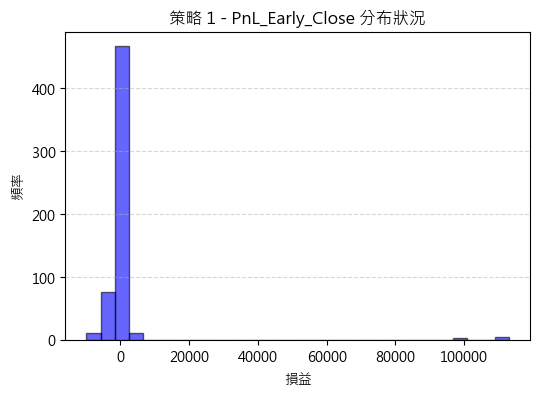

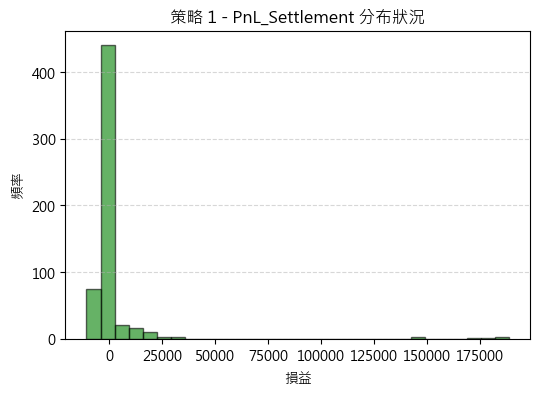

In [91]:
def plot_pnl_distribution(df_list, strategy_names):
    """分別繪製 PnL_Early_Close 和 PnL_Settlement 的直方圖"""
    
    for df, strategy in zip(df_list, strategy_names):
        # **PnL_Early_Close 直方圖**
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(df["PnL_Early_Close"], bins=30, alpha=0.6, color="blue", edgecolor="black")
        ax.set_title(f"{strategy} - PnL_Early_Close 分布狀況", fontsize=12)
        ax.set_xlabel("損益", fontsize=10)
        ax.set_ylabel("頻率", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負數正常顯示
        plt.show()

        # **PnL_Settlement 直方圖**
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(df["PnL_Settlement"], bins=30, alpha=0.6, color="green", edgecolor="black")
        ax.set_title(f"{strategy} - PnL_Settlement 分布狀況", fontsize=12)
        ax.set_xlabel("損益", fontsize=10)
        ax.set_ylabel("頻率", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負數正常顯示
        plt.show()

# **測試函數**
plot_pnl_distribution(df_list, strategy_names)

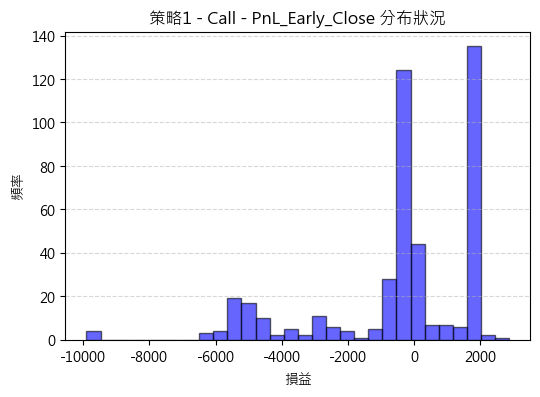

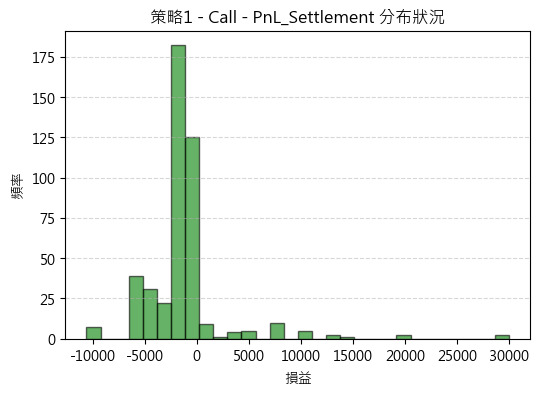

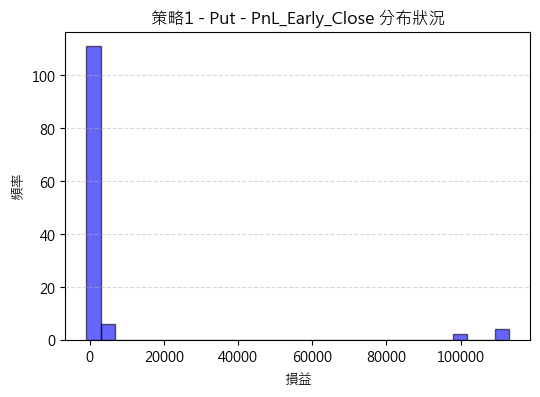

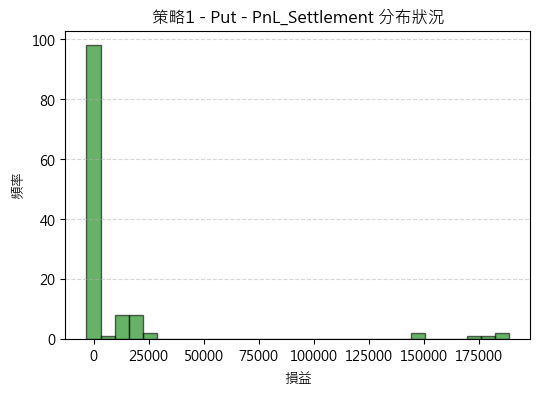

In [92]:
plot_pnl_distribution(df_list_1, strategy_names_1)

In [101]:
# **計算 PnL_Early_Close 的極端值範圍**
lower_bound_early, upper_bound_early, _, _, _, _ = detect_extreme_values(df_new_1, "PnL_Early_Close")

# **計算 PnL_Settlement 的極端值範圍**
lower_bound_settle, upper_bound_settle, _, _, _, _ = detect_extreme_values(df_new_1, "PnL_Settlement")

# **保留兩者皆非極端值的記錄**
df_clean = df_new_1[
    (df_new_1["PnL_Early_Close"] >= lower_bound_early) & (df_new_1["PnL_Early_Close"] <= upper_bound_early) &
    (df_new_1["PnL_Settlement"] >= lower_bound_settle) & (df_new_1["PnL_Settlement"] <= upper_bound_settle)]

# **查看結果**
print("📌 只保留 PnL_Early_Close 與 PnL_Settlement 都不是極端值的 DataFrame：")
display(df_clean)

📌 只保留 PnL_Early_Close 與 PnL_Settlement 都不是極端值的 DataFrame：


,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,...,DateTime,SameStrikePrice,Delta,Vega,NewPrice,NewDate,NumMatchingTrades,Intrinsic_Value,PnL_Early_Close,PnL_Settlement
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,...,40500,5.783333,0.040502,3.092317,6.6,2024-02-01,24,32.0,18.214167,1269.544167
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,...,45200,6.14,-0.046538,2.442855,5.882589,2024-02-23,224,0.0,-35.471665,-348.307
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,...,44600,3.3,-0.019743,1.03441,3.82,2024-03-11,10,0.0,3.644,-207.165
5,2024-03-13 04:45:00,P,0.4,TX219300O4,11.0,19300.0,19993.0,2024-03-13,202403W2,19931,...,44500,0.4,-0.004676,0.085659,0.430556,2024-03-13,36,0.0,-20.51375,-62.02
6,2024-04-17 04:05:00,C,0.7,TXO20450D4,11.0,20450.0,19927.0,2024-04-17,202404,20238,...,40500,0.7,0.009492,0.165858,0.666667,2024-04-17,24,0.0,-23.735,-77.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,2025-04-03 04:38:00,C,53.0,TX221900D5,14.0,21900.0,21046.0,2025-04-03,202504W2,17430,...,43800,47.75974,0.131802,5.933476,4.437319,2025-04-07,276,0.0,-2190.730924,-2429.375
578,2025-04-03 04:44:00,C,52.0,TX221800D5,14.0,21800.0,20961.0,2025-04-03,202504W2,17430,...,44400,48.288462,0.133289,5.9527,4.397324,2025-04-07,299,0.0,-2219.191145,-2455.8375
583,2025-04-03 04:45:00,C,52.0,TX221800D5,14.0,21800.0,20854.0,2025-04-03,202504W2,17430,...,44500,47.210526,0.128696,5.801957,4.397324,2025-04-07,299,0.0,-2165.240488,-2401.886842
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,...,41500,93.0,0.226661,7.075159,88.608939,2025-04-18,179,0.0,-250.63352,-4696.65


In [100]:
df_clean.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_clean_1.csv',index = False, encoding = 'utf-8-sig')

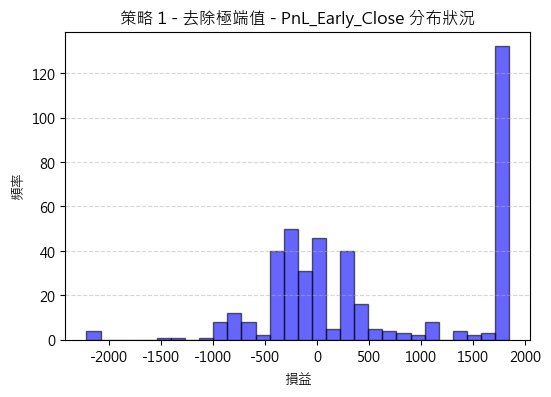

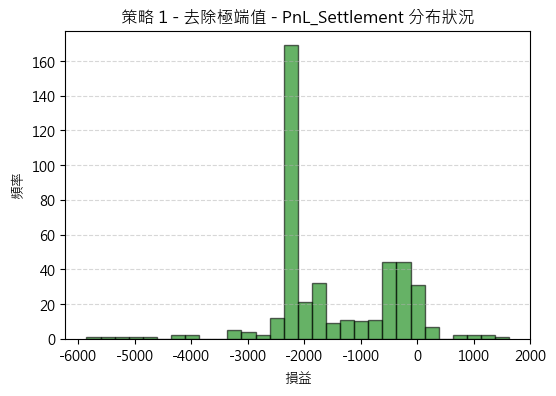

In [103]:
df_list_11 = [df_clean]
strategy_names_11 = ["策略 1 - 去除極端值"]

plot_pnl_distribution(df_list_11, strategy_names_11)

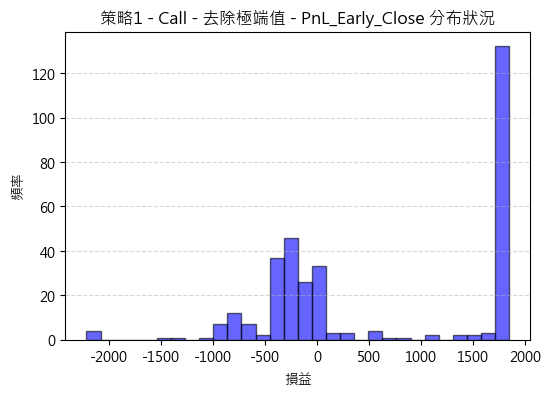

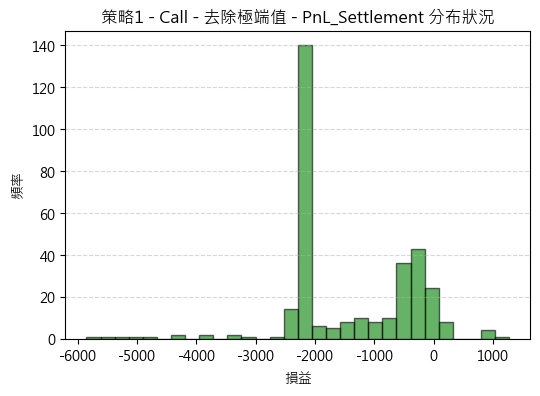

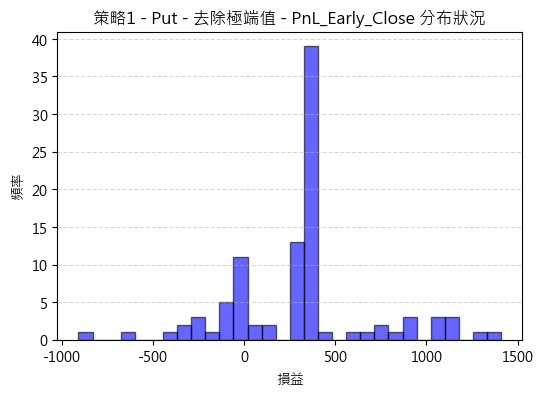

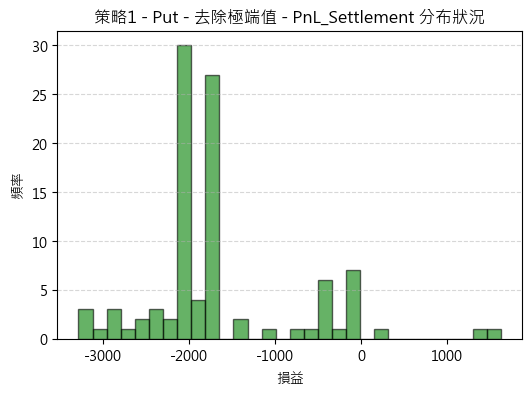

In [104]:
df_new_11_call = df_clean[df_clean["Category"] == "C"]
df_new_11_put = df_clean[df_clean["Category"] == "P"]

df_list_111 = [df_new_11_call, df_new_11_put]
strategy_names_111 = ["策略1 - Call - 去除極端值", "策略1 - Put - 去除極端值"]
plot_pnl_distribution(df_list_111, strategy_names_111)

3.	觀察每日損益波動情況，還有看月損益等等
	損益波動情況
1.	原始-平倉，著重在PnL上之變化
(以類似股價圖呈現，下面附上各個時間點之數量)
2.	原始-持有至到期日，以PnL去看
3.	分為C、P去看


#### 逐日績效累積觀察

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


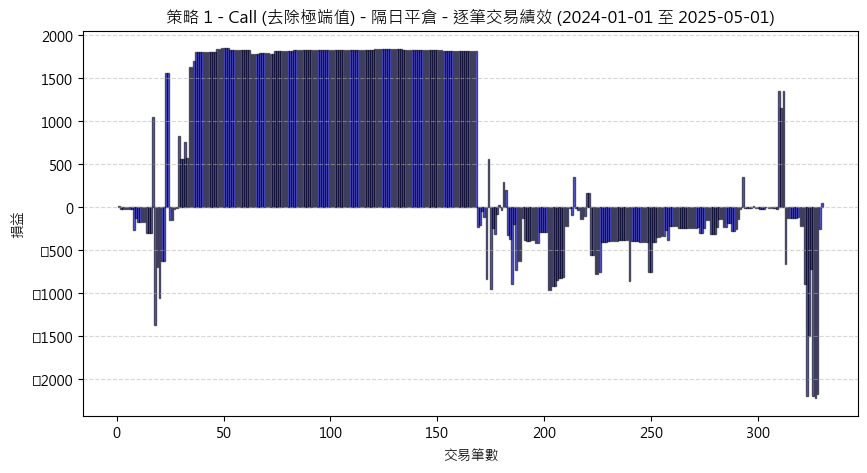

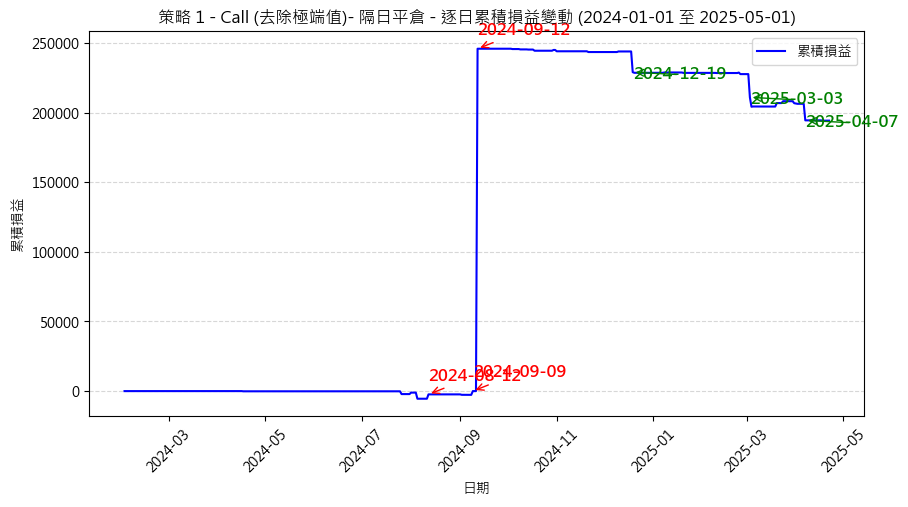

In [107]:
def format_date_range(start_date, end_date):
    """格式化時間範圍為 YYYY-MM-DD"""
    return f"{start_date.strftime('%Y-%m-%d')} 至 {end_date.strftime('%Y-%m-%d')}" if start_date and end_date else ""

def plot_trade_performance(df, strategy_name, start_date=None, end_date=None):
    """繪製逐筆績效表現（長條圖），可選擇時間範圍"""
    
    df = df.copy()
    df.loc[:, "NewDate"] = pd.to_datetime(df["NewDate"])  # **確保日期格式正確**
    
    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["NewDate"] >= start_date) & (df["NewDate"] <= end_date)]
    
    df["Trade_Index"] = range(1, len(df) + 1)  # **為每筆交易建立索引**
    
    plt.figure(figsize=(10, 5))
    plt.bar(df["Trade_Index"], df["PnL_Early_Close"], color="blue", alpha=0.6, edgecolor="black")
    date_range_str = format_date_range(start_date, end_date)
    plt.title(f"{strategy_name} - 隔日平倉 - 逐筆交易績效 ({date_range_str})")
    plt.xlabel("交易筆數")
    plt.ylabel("損益")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

def plot_daily_cumulative_pnl(df, strategy_name, start_date=None, end_date=None):
    """繪製逐日累積損益走勢，可選擇時間範圍"""
    
    df = df.copy()
    df.loc[:, "NewDate"] = pd.to_datetime(df["NewDate"])  # **確保日期為 datetime**
    
    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["NewDate"] >= start_date) & (df["NewDate"] <= end_date)]
    
    # **將同一天的數據加總**
    df_daily = df.groupby("NewDate", as_index=False)["PnL_Early_Close"].sum()
    
    # **填補缺失日期（視為損益持平）**
    full_dates = pd.date_range(start=df_daily["NewDate"].min(), end=df_daily["NewDate"].max(), freq="D")
    df_daily = df_daily.set_index("NewDate").reindex(full_dates, fill_value=0).reset_index()
    df_daily.rename(columns={"index": "NewDate"}, inplace=True)
    
    # **計算累積損益**
    df_daily["Cumulative_PnL"] = df_daily["PnL_Early_Close"].cumsum()

    # **識別異常變動點**
    df_daily["PnL_Change"] = df_daily["Cumulative_PnL"].diff()
    # **確保 'PnL_Change' 欄位是 float 型態**
    df_daily["PnL_Change"] = pd.to_numeric(df_daily["PnL_Change"], errors="coerce")

    # **去除 NaN 值**
    df_daily = df_daily.dropna(subset=["PnL_Change"])
    highlight_dates_1 = df_daily.nlargest(3, "PnL_Change")["NewDate"]  # **找出變動最大的3天**
    highlight_dates_2 = df_daily.nsmallest(3, "PnL_Change")["NewDate"]  # **找出變動最小的3天**

    # **繪製累積損益折線圖**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_daily["NewDate"], df_daily["Cumulative_PnL"], color="blue", linestyle="-", label="累積損益")

    # **標註異常波動點（向上移動，標註文字改為紅色）**
    for date in highlight_dates_1:
        pnl_value = df_daily.loc[df_daily["NewDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 10000),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="red"),
                    color="red", fontsize=12, fontweight="bold")  # **標註日期為紅色**
    
    for date in highlight_dates_2:
        pnl_value = df_daily.loc[df_daily["NewDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value - 5000),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="green"),
                    color="green", fontsize=12, fontweight="bold")  # **標註日期為紅色**


    date_range_str = format_date_range(start_date, end_date)
    ax.set_title(f"{strategy_name}- 隔日平倉 - 逐日累積損益變動 ({date_range_str})")
    ax.set_xlabel("日期")
    ax.set_ylabel("累積損益")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()




plot_trade_performance(df_new_11_call, "策略 1 - Call (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")
plot_daily_cumulative_pnl(df_new_11_call, "策略 1 - Call (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")


c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


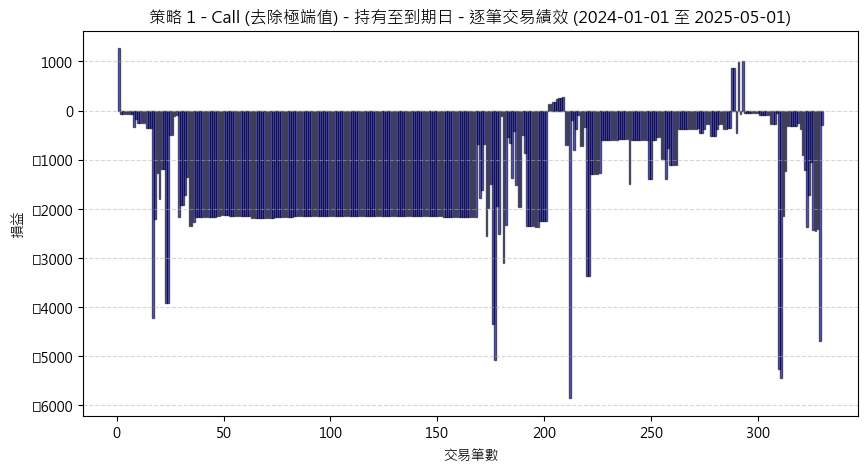

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


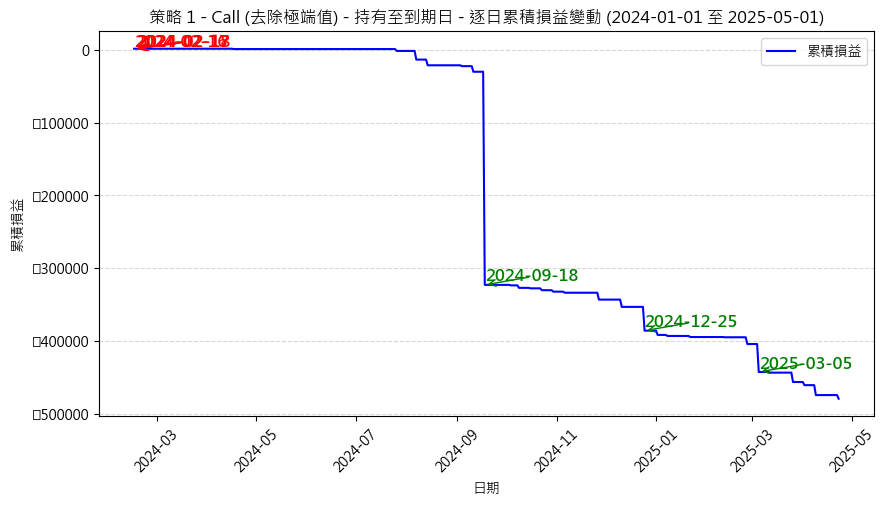

In [108]:
def format_date_range(start_date, end_date):
    """格式化時間範圍為 YYYY-MM-DD"""
    return f"{start_date.strftime('%Y-%m-%d')} 至 {end_date.strftime('%Y-%m-%d')}" if start_date and end_date else ""

def plot_trade_performance_settlement(df, strategy_name, start_date=None, end_date=None):
    """繪製逐筆交易績效（長條圖），標題顯示簡化時間格式"""
    
    df = df.copy()
    df.loc[:, "SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **確保日期格式正確**
    
    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["SettlementDate"] >= start_date) & (df["SettlementDate"] <= end_date)]
    
    df["Trade_Index"] = range(1, len(df) + 1)  # **為每筆交易建立索引**
    
    plt.figure(figsize=(10, 5))
    plt.bar(df["Trade_Index"], df["PnL_Settlement"], color="blue", alpha=0.6, edgecolor="black")
    
    # **簡化時間範圍**
    date_range_str = format_date_range(start_date, end_date)
    plt.title(f"{strategy_name} - 持有至到期日 - 逐筆交易績效 ({date_range_str})")
    
    plt.xlabel("交易筆數")
    plt.ylabel("損益")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

def plot_daily_cumulative_pnl_settlement(df, strategy_name, start_date=None, end_date=None):
    """繪製逐日累積損益走勢，標題顯示簡化時間格式"""
    
    df = df.copy()
    df.loc[:, "SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **確保日期格式正確**

    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["SettlementDate"] >= start_date) & (df["SettlementDate"] <= end_date)]
    
    # **將同一天的數據加總**
    df_daily = df.groupby("SettlementDate", as_index=False)["PnL_Settlement"].sum()

    # **填補缺失日期（視為損益持平）**
    full_dates = pd.date_range(start=df_daily["SettlementDate"].min(), end=df_daily["SettlementDate"].max(), freq="D")
    df_daily = df_daily.set_index("SettlementDate").reindex(full_dates, fill_value=0).reset_index()
    df_daily.rename(columns={"index": "SettlementDate"}, inplace=True)

    # **計算累積損益**
    df_daily["Cumulative_PnL"] = df_daily["PnL_Settlement"].cumsum()

    # **識別異常變動點**
    df_daily["PnL_Change"] = df_daily["Cumulative_PnL"].diff()
    # **確保 'PnL_Change' 欄位是 float 型態**
    df_daily["PnL_Change"] = pd.to_numeric(df_daily["PnL_Change"], errors="coerce")

    # **去除 NaN 值**
    df_daily = df_daily.dropna(subset=["PnL_Change"])
    highlight_dates_1 = df_daily.nlargest(3, "PnL_Change")["SettlementDate"]  # **找出變動最大的3天**
    highlight_dates_2 = df_daily.nsmallest(3, "PnL_Change")["SettlementDate"]  # **找出變動最大的3天**

    # **繪製累積損益折線圖**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_daily["SettlementDate"], df_daily["Cumulative_PnL"], color="blue", linestyle="-", label="累積損益")

    # **簡化時間標題**
    date_range_str = format_date_range(start_date, end_date)
    # **標註異常波動點（向上移動，標註文字改為紅色）**
    for date in highlight_dates_1:
        pnl_value = df_daily.loc[df_daily["SettlementDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 2500),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="red"),
                    color="red", fontsize=12, fontweight="bold")  # **標註日期為紅色*

    for date in highlight_dates_2:
        pnl_value = df_daily.loc[df_daily["SettlementDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 5000),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="green"),
                    color="green", fontsize=12, fontweight="bold")  # **標註日期為紅色**


    ax.set_title(f"{strategy_name} - 持有至到期日 - 逐日累積損益變動 ({date_range_str})")
    ax.set_xlabel("日期")
    ax.set_ylabel("累積損益")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

# **執行可視化**
plot_trade_performance_settlement(df_new_11_call, "策略 1 - Call (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")
plot_daily_cumulative_pnl_settlement(df_new_11_call, "策略 1 - Call (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")


In [ ]:
df_new_1_adjusted.to_csv("")

#### 逐月績效累積觀察

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


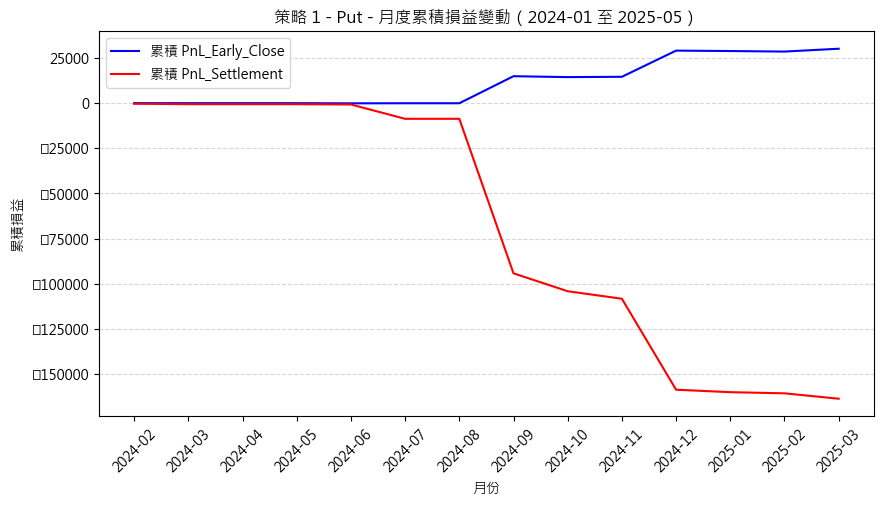

In [51]:
def plot_monthly_cumulative_pnl(df, strategy_name, start_date=None, end_date=None):
    """繪製月度累積損益走勢，可同步顯示平倉與持有至到期日績效"""

    df = df.copy()

    # **確保 'NewDate' 欄位為 datetime64 型態**
    df["NewDate"] = pd.to_datetime(df["NewDate"], errors="coerce")

    # **移除任何可能的 NaN 值**
    df = df.dropna(subset=["NewDate"])

    # **再確認型態**
    assert df["NewDate"].dtype == "datetime64[ns]", "NewDate 欄位仍不是 datetime 格式！請檢查原始資料。"

    # **轉換為月份**
    df["Month"] = df["NewDate"].dt.to_period("M")


    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["NewDate"] >= start_date) & (df["NewDate"] <= end_date)]

    # **將同一個月的數據加總**
    df_monthly = df.groupby("Month", as_index=False)[["PnL_Early_Close", "PnL_Settlement"]].sum()

    # **填補缺失月份（視為損益持平）**
    full_months = pd.period_range(start=df_monthly["Month"].min(), end=df_monthly["Month"].max(), freq="M")
    df_monthly = df_monthly.set_index("Month").reindex(full_months, fill_value=0).reset_index()
    df_monthly.rename(columns={"index": "Month"}, inplace=True)

    # **計算累積損益**
    df_monthly["Cumulative_PnL_Early_Close"] = df_monthly["PnL_Early_Close"].cumsum()
    df_monthly["Cumulative_PnL_Settlement"] = df_monthly["PnL_Settlement"].cumsum()

    # **繪製累積損益折線圖**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_monthly["Month"].astype(str), df_monthly["Cumulative_PnL_Early_Close"], color="blue", linestyle="-", label="累積 PnL_Early_Close")
    ax.plot(df_monthly["Month"].astype(str), df_monthly["Cumulative_PnL_Settlement"], color="red", linestyle="-", label="累積 PnL_Settlement")
    
    ax.set_title(f"{strategy_name} - 月度累積損益變動（{start_date.strftime('%Y-%m')} 至 {end_date.strftime('%Y-%m')}）" if start_date and end_date else f"{strategy_name} - 月度累積損益變動")
    ax.set_xlabel("月份")
    ax.set_ylabel("累積損益")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

# **執行可視化**
plot_monthly_cumulative_pnl(df_new_11_put, "策略 1 - Put", start_date="2024-01-01", end_date="2025-05-01")


#### 繪製Delta變化圖

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


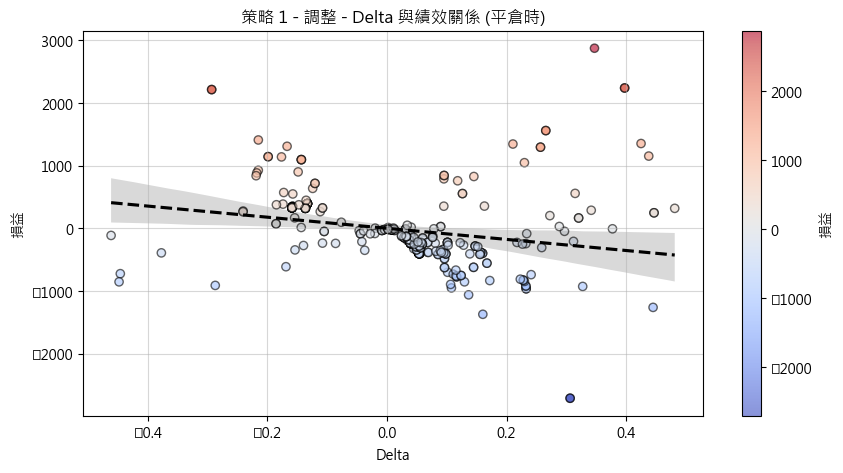

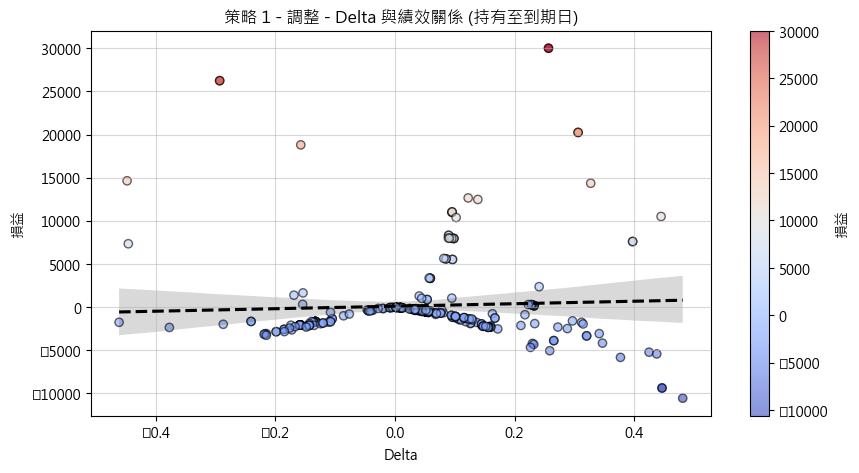

In [145]:
def plot_delta_vs_pnl(df, strategy_name, use_settlement=False):
    """繪製 Delta 與損益的關係（散點圖）"""

    df = df.copy()
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")  # **確保 Delta 為數值**
    
    # **選擇 PnL**
    pnl_col = "PnL_Settlement" if use_settlement else "PnL_Early_Close"
    df[pnl_col] = pd.to_numeric(df[pnl_col], errors="coerce")  # **確保 PnL 為數值**
    
    # **移除 NaN 值**
    df = df.dropna(subset=["Delta", pnl_col])
    
    # **繪製散點圖**
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(df["Delta"], df[pnl_col], c=df[pnl_col], cmap="coolwarm", alpha=0.6, edgecolors="black")

    # **加入顏色條**
    cbar = plt.colorbar(scatter)
    cbar.set_label("損益")

    # **趨勢線**
    sns.regplot(x=df["Delta"], y=df[pnl_col], scatter=False, line_kws={"color": "black", "linestyle": "--"})

    plt.title(f"{strategy_name} - Delta 與績效關係 ({'持有至到期日' if use_settlement else '平倉時'})")
    plt.xlabel("Delta")
    plt.ylabel("損益")
    plt.grid(alpha=0.5)
    plt.show()

# **執行可視化**
plot_delta_vs_pnl(df_new_1_adjusted, "策略 1 - 調整", use_settlement=False)  # **使用平倉 PnL**
plot_delta_vs_pnl(df_new_1_adjusted, "策略 1 - 調整", use_settlement=True)  # **使用持有至到期日 PnL**


計算逐日Delta累積

隔日平倉策略：每天都是全新的一天

持有到到期日策略：累積到到期日前 (觀察累積之Delta大小)

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_6332\3478287247.py:75: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


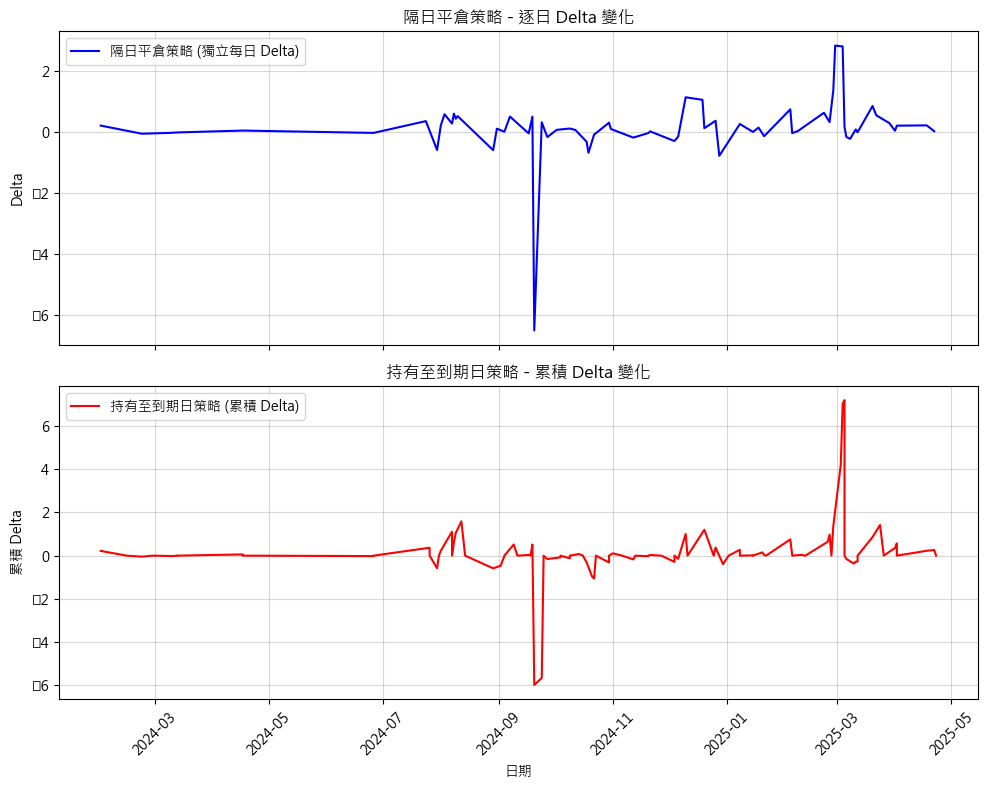

In [146]:
def prepare_delta_data(df):
    """準備 Delta 數據，確保其為數值型態"""
    
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])  # **確保 Date 為 datetime**
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **確保 SettlementDate 為 datetime**
    df["NewDate"] = pd.to_datetime(df["NewDate"])

    # **確保 Delta 是數值型態**
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")

    # **移除 NaN，避免影響計算**
    df = df.dropna(subset=["Date", "SettlementDate", "NewDate", "Delta"])

    return df

def calculate_daily_delta(df):
    """隔日平倉策略：每天的 Delta 不累積，僅計算當天值"""
    df_daily = df.groupby("Date", as_index=False)["Delta"].sum()
    df_daily.rename(columns={"Delta": "Daily_Delta"}, inplace=True)
    return df_daily

def calculate_cumulative_delta(df):
    """持有至到期日策略：每日 Delta 累積，並在 SettlementDate 到期時扣除相應數據"""
    
    # **確保數據格式**
    df = df.copy()
    df["NewDate"] = pd.to_datetime(df["NewDate"])  # **轉換 NewDate 為 datetime**
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **轉換 SettlementDate 為 datetime**
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")  # **確保 Delta 為數值型態**
    
    # **移除 NaN，避免錯誤計算**
    df = df.dropna(subset=["NewDate", "SettlementDate", "Delta"])
    
    # **計算每日 Delta（累積）**
    df_daily = df.groupby("NewDate", as_index=False)["Delta"].sum()
    df_daily["Cumulative_Delta"] = df_daily["Delta"].cumsum()

    # **處理 SettlementDate 到期時的扣除**
    df_settlement = df.groupby("SettlementDate", as_index=False)["Delta"].sum()
    df_settlement["NewDate"] = df_settlement["SettlementDate"]  # **將到期日映射為要扣除的日期**
    df_settlement["Delta"] = -df_settlement["Delta"]  # **轉為負數（表示扣除）**

    # **合併每日累積數據 & 到期日扣除數據**
    df_combined = pd.concat([df_daily, df_settlement], ignore_index=True).sort_values("NewDate")
    df_combined["Cumulative_Delta_Adjusted"] = df_combined["Delta"].cumsum()
    df_combined["Cumulative_Delta"] = df_combined["Cumulative_Delta"].fillna(0)

    # **確保輸出日期欄位名稱一致**
    df_combined.rename(columns={"NewDate": "Date"}, inplace=True)

    return df_combined

def plot_delta_trends(df_daily, df_cumulative):
    """繪製 Delta 累積趨勢比較"""

    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # **隔日平倉策略**
    ax[0].plot(df_daily["Date"], df_daily["Daily_Delta"], color="blue", linestyle="-", label="隔日平倉策略 (獨立每日 Delta)")
    ax[0].set_title("隔日平倉策略 - 逐日 Delta 變化")
    ax[0].set_ylabel("Delta")
    ax[0].legend()
    ax[0].grid(alpha=0.5)

    # **持有至到期日策略**
    ax[1].plot(df_cumulative["Date"], df_cumulative["Cumulative_Delta_Adjusted"], color="red", linestyle="-", label="持有至到期日策略 (累積 Delta)")
    ax[1].set_title("持有至到期日策略 - 累積 Delta 變化")
    ax[1].set_xlabel("日期")
    ax[1].set_ylabel("累積 Delta")
    ax[1].legend()
    ax[1].grid(alpha=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# **執行完整流程**
df_clean = prepare_delta_data(df_new_1_adjusted)
df_daily_delta = calculate_daily_delta(df_clean)
df_cumulative_delta = calculate_cumulative_delta(df_clean)
plot_delta_trends(df_daily_delta, df_cumulative_delta)


In [119]:
date_counts = df_new_1["Date"].value_counts().reset_index()
date_counts.columns = ["Date", "Count"]
date_counts = date_counts.sort_values(by="Count", ascending=False)  # **由高到低排序**

# **顯示前 10 名**
print(date_counts.head(10))


         Date  Count
0  2024-09-12    136
1  2025-04-03     94
2  2024-12-19     49
3  2025-03-04     47
4  2024-09-20     44
5  2025-02-28     39
6  2025-03-05     19
7  2024-07-24     14
8  2024-08-02     14
9  2025-03-29      7


C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_6332\2109450897.py:44: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


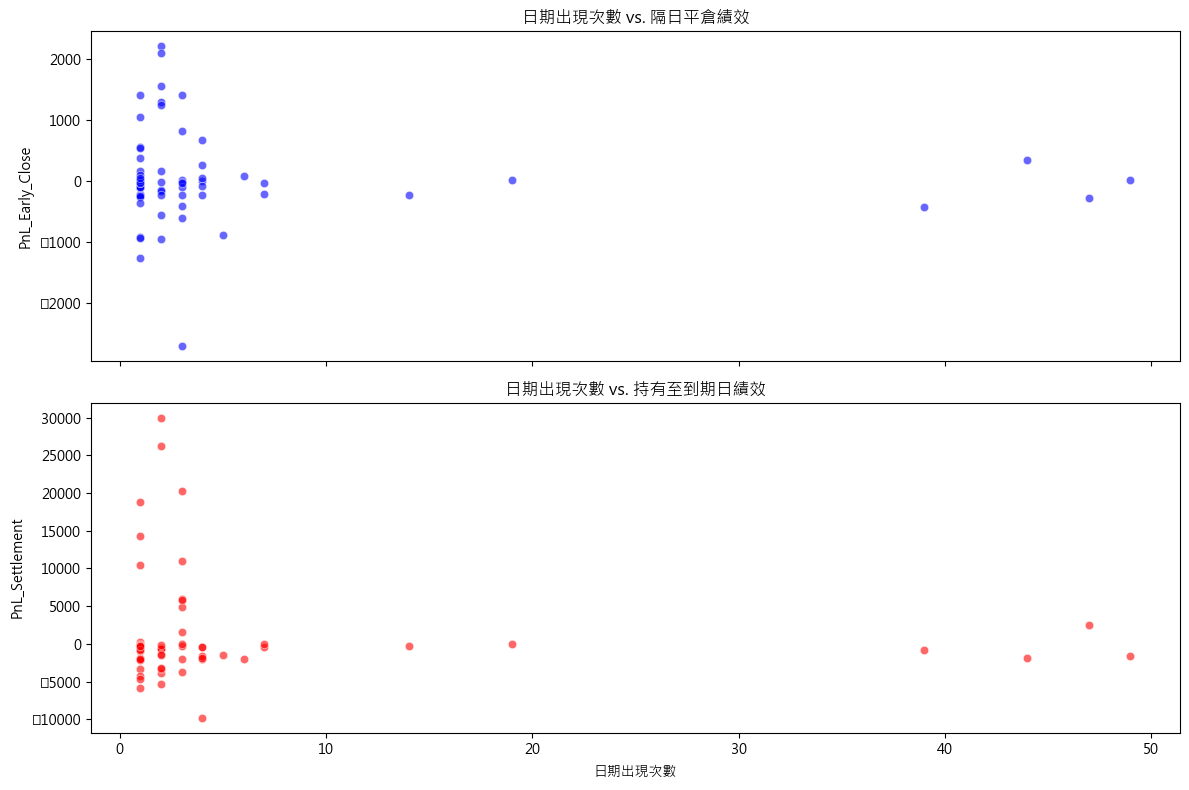

In [147]:
def analyze_date_performance(df):
    """分析日期出現次數與績效的關係"""
    
    df = df.copy()
    
    # **確保數據格式正確**
    df["Date"] = pd.to_datetime(df["Date"])  # 確保 Date 是 datetime
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])
    df["PnL_Early_Close"] = pd.to_numeric(df["PnL_Early_Close"], errors="coerce")
    df["PnL_Settlement"] = pd.to_numeric(df["PnL_Settlement"], errors="coerce")
    
    # **計算日期出現次數**
    date_counts = df["Date"].value_counts().reset_index()
    date_counts.columns = ["Date", "Count"]
    
    # **按日期計算平均績效**
    df_performance = df.groupby("Date").agg({
        "PnL_Early_Close": "mean",
        "PnL_Settlement": "mean"
    }).reset_index()
    
    # **合併日期頻率與績效數據**
    df_analysis = date_counts.merge(df_performance, on="Date", how="left")
    
    return df_analysis

def plot_date_vs_pnl(df_analysis):
    """視覺化日期頻率 vs. PnL 表現"""
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # **散點圖：日期頻率 vs. 隔日平倉績效**
    sns.scatterplot(x=df_analysis["Count"], y=df_analysis["PnL_Early_Close"], ax=ax[0], color="blue", alpha=0.6)
    ax[0].set_title("日期出現次數 vs. 隔日平倉績效")
    ax[0].set_xlabel("日期出現次數")
    ax[0].set_ylabel("PnL_Early_Close")

    # **散點圖：日期頻率 vs. 持有至到期日績效**
    sns.scatterplot(x=df_analysis["Count"], y=df_analysis["PnL_Settlement"], ax=ax[1], color="red", alpha=0.6)
    ax[1].set_title("日期出現次數 vs. 持有至到期日績效")
    ax[1].set_xlabel("日期出現次數")
    ax[1].set_ylabel("PnL_Settlement")

    plt.tight_layout()
    plt.show()

# **執行完整分析**
df_analysis = analyze_date_performance(df_new_1_adjusted)
plot_date_vs_pnl(df_analysis)


C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_6332\3397325574.py:67: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


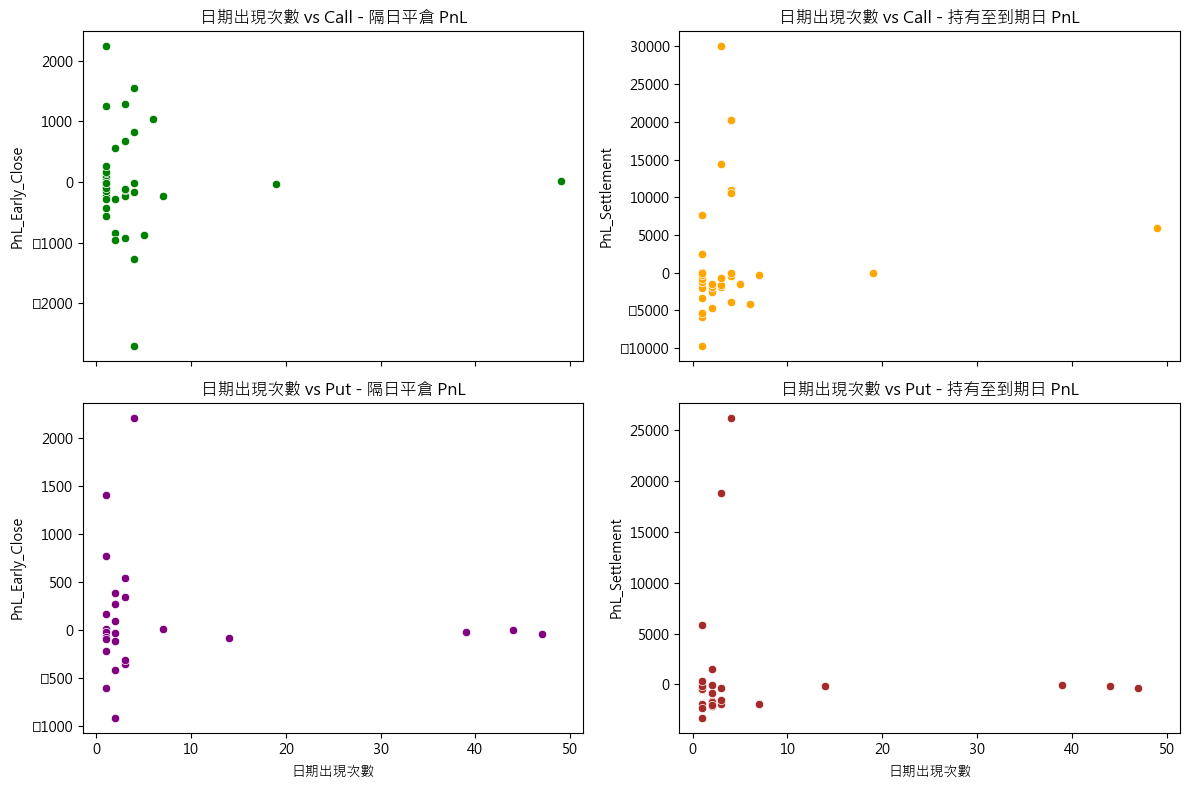

In [148]:
def analyze_option_date_performance(df):
    """分析日期出現次數與 Call/Put 交易及其績效關係"""
    
    df = df.copy()
    
    # **確保數據格式正確**
    df["Date"] = pd.to_datetime(df["Date"])  
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])
    df["PnL_Early_Close"] = pd.to_numeric(df["PnL_Early_Close"], errors="coerce")
    df["PnL_Settlement"] = pd.to_numeric(df["PnL_Settlement"], errors="coerce")

    # **計算日期出現次數**
    date_counts = df["Date"].value_counts().reset_index()
    date_counts.columns = ["Date", "Count"]
    
    # **按日期計算 Call & Put 數量**
    df_call = df[df["Category"] == "C"]
    df_put = df[df["Category"] == "P"]

    call_counts = df_call["Date"].value_counts().reset_index()
    call_counts.columns = ["Date", "Call_Count"]
    
    put_counts = df_put["Date"].value_counts().reset_index()
    put_counts.columns = ["Date", "Put_Count"]

    # **按日期計算 PnL**
    df_pnl = df.groupby(["Date", "Category"]).agg({
        "PnL_Early_Close": "mean",
        "PnL_Settlement": "mean"
    }).reset_index()

    return date_counts, call_counts, put_counts, df_pnl

def plot_option_date_relationship(date_counts, df_pnl):
    """視覺化 日期出現次數 vs Call/Put PnL 表現"""

    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # **日期出現次數 vs Call - 隔日平倉 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "C"]["PnL_Early_Close"], ax=ax[0, 0], color="green")
    ax[0, 0].set_title("日期出現次數 vs Call - 隔日平倉 PnL")
    ax[0, 0].set_xlabel("日期出現次數")
    ax[0, 0].set_ylabel("PnL_Early_Close")

    # **日期出現次數 vs Call - 持有至到期日 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "C"]["PnL_Settlement"], ax=ax[0, 1], color="orange")
    ax[0, 1].set_title("日期出現次數 vs Call - 持有至到期日 PnL")
    ax[0, 1].set_xlabel("日期出現次數")
    ax[0, 1].set_ylabel("PnL_Settlement")

    # **日期出現次數 vs Put - 隔日平倉 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "P"]["PnL_Early_Close"], ax=ax[1, 0], color="purple")
    ax[1, 0].set_title("日期出現次數 vs Put - 隔日平倉 PnL")
    ax[1, 0].set_xlabel("日期出現次數")
    ax[1, 0].set_ylabel("PnL_Early_Close")

    # **日期出現次數 vs Put - 持有至到期日 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "P"]["PnL_Settlement"], ax=ax[1, 1], color="brown")
    ax[1, 1].set_title("日期出現次數 vs Put - 持有至到期日 PnL")
    ax[1, 1].set_xlabel("日期出現次數")
    ax[1, 1].set_ylabel("PnL_Settlement")

    plt.tight_layout()
    plt.show()



# **執行完整分析**
date_counts, call_counts, put_counts, df_pnl = analyze_option_date_performance(df_new_1_adjusted)
plot_option_date_relationship(date_counts, df_pnl)


### 2. 選擇價平的 
看當前期貨價格在哪，選擇靠近它的

針對df_new_2中的FutPrice，去對應到df_tick_1中觀察是否有相近之履約價格

先跟據逐筆df_new_2去做觀察，連結df_new_2 與 df_tick_1
1. df_new_2 的ProductCode = df_tick_1 的 到期月份(週別)
2. df_new_2 的Category = df_tick_1 的 買賣權別
3. df_new_2 的Date = df_tick_1 的 TradeDate

接著針對df_new_2的 DateTime，去找df_tick_1鄰近之成交時間 (5分鐘內)，找尋在時間內出現的所有履約價，抓取FutPrice-履約價格最小值之履約價格，同時根據此履約價，在5分鐘內計算其數據之選擇權成交價格之平均

最後將其成交價格之平均儲存在df_new_2中，欄位名稱為 AtTheMoneyPrice，然後也將其新的履約價加入，欄位名稱為AtTheMoneyStrikePrice

In [119]:
df_new_2 = df_new_0.copy()

In [120]:
# **確保 `成交時間` 為 `INT` 格式**
df_tick_1["成交時間"] = df_tick_1["成交時間"].astype(int)

# **初始化新欄位**
df_new_2["AtTheMoneyStrikePrice"] = None  # 最接近的履約價格
df_new_2["AtTheMoneyPrice"] = None  # 選擇權成交均價
df_new_2["Delta"] = None
df_new_2["Vega"] = None

# **遍歷 `df_new_2` 的每一筆 FutPrice**
for idx, row in df_new_2.iterrows():
    fut_price = row["FutPrice"]
    product_code = row["ProductCode"]
    category = row["Category"]
    date = row["Date"]
    time = row["DateTime"]

    # **篩選符合 `ProductCode`、`Category`、`TradeDate` 的 `df_tick_1` 數據**
    filtered_tick = df_tick_1[
        (df_tick_1["到期月份(週別)"] == product_code) &
        (df_tick_1["買賣權別"] == category) &
        (df_tick_1["TradeDate"] == date)
    ]
    
    # **篩選 5 分鐘內的 `成交時間`**
    time_window = filtered_tick[
        (filtered_tick["成交時間"].astype(int) >= int(time)) & 
        (filtered_tick["成交時間"].astype(int) <= int(time) + 500)
        ]
    
    # **計算 `FutPrice` 與 `履約價格` 的價差**
    time_window["PriceDiff"] = abs(time_window["履約價格"] - fut_price)

    # **找出 `PriceDiff` 最小的履約價格**
    best_strike = time_window.loc[time_window["PriceDiff"].idxmin(), "履約價格"] if not time_window.empty else None
    
    # **記錄最佳履約價格**
    df_new_2.at[idx, "AtTheMoneyStrikePrice"] = best_strike
    
    # **計算該履約價格在 5 分鐘內的選擇權成交均價 & 平均 Delta/Vega**
    if best_strike:
        avg_option_price = time_window[time_window["履約價格"] == best_strike]["成交價格"].mean()
        avg_delta = time_window[time_window["履約價格"] == best_strike]["delta"].mean()
        avg_vega = time_window[time_window["履約價格"] == best_strike]["vega"].mean()

        df_new_2.at[idx, "AtTheMoneyPrice"] = avg_option_price
        df_new_2.at[idx, "Delta"] = avg_delta
        df_new_2.at[idx, "Vega"] = avg_vega

    
# **檢查結果**
print("📌 `AtTheMoneyPrice`、`Delta`、`Vega` 計算完成：")
print(df_new_2.head())
print(f"✅ 更新後數據量: {len(df_new_2)}")

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4928\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["履約價格"] - fut_price)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4928\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["履約價格"] - fut_price)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4928\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy o

📌 `AtTheMoneyPrice`、`Delta`、`Vega` 計算完成：
                  Time Category  Price          ID   Fee  StrikePrice  \
0  2024-02-01 04:05:00        C    7.0  TX118600B4  11.0      18600.0   
1  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
2  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
3  2024-02-23 04:52:00        P    6.4  TX418500N4  11.0      18500.0   
4  2024-03-09 04:46:00        P    3.3  TX218850O4  11.0      18850.0   

   FutPrice        Date ProductCode  SettlementPrice SettlementDate  DateTime  \
0   17917.0  2024-02-01    202402W1            18632     2024-02-15     40500   
1   17910.0  2024-02-01    202402W1            18632     2024-02-15     41000   
2   17913.0  2024-02-01    202402W1            18632     2024-02-15     41000   
3   18994.0  2024-02-23    202402W4            18993     2024-02-29     45200   
4   19744.0  2024-03-09    202403W2            19931     2024-03-13     44600   

  AtTheMoneyStrikePrice AtTheMone

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4928\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["履約價格"] - fut_price)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_4928\4206482200.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window["PriceDiff"] = abs(time_window["履約價格"] - fut_price)


In [121]:
df_new_2 = calculate_new_price(df_tick, df_new_2, "AtTheMoneyStrikePrice")  # **策略 2**
print(f"✅ `df_new_2` 數據量: {len(df_new_2)}")

✅ `df_new_2` 數據量: 592


In [122]:
df_new_2 = calculate_pnl(df_new_2, "AtTheMoneyStrikePrice", "AtTheMoneyPrice")  # **策略 2**
print(f"✅ `df_new_2` 數據量: {len(df_new_2)}")

✅ `df_new_2` 數據量: 592


In [123]:
# **測試函數**
strategy_names = ["策略 2"]
df_list = [df_new_2]

df_performance_styled = generate_performance_table(df_list, strategy_names)

from IPython.display import display
print("📌 策略績效表格（包含所有策略）：")
display(df_performance_styled)  # **顯示格式化表格**

📌 策略績效表格（包含所有策略）：


,指標,策略 2 - 提前平倉,策略 2 - 持有至到期
0,累積損益,28094.97,1183900.31
1,勝率 (%),53.04,31.42
2,賺賠比,0.91,2.96
3,平均損益,47.46,1999.83


In [124]:
df_performance_styled = generate_performance_summary(df_list, strategy_names)
df_extreme_events = generate_extreme_event_summary(df_list, strategy_names)

from IPython.display import display
print("📌 策略績效表格（去除極端值後）：")
display(df_performance_styled)

print("\n📌 極端事件列表：")
display(df_extreme_events)


📌 策略 2 極端事件統計：
極端獲利 - 提前平倉：7 次
極端虧損 - 提前平倉：104 次
極端獲利 - 持有至到期：8 次
極端虧損 - 持有至到期：0 次
📌 策略績效表格（去除極端值後）：


,指標,策略 2 - 提前平倉,策略 2 - 持有至到期
0,累積損益,273283.92,1367.25
1,勝率 (%),63.83,30.48
2,賺賠比,1.16,2.28
3,平均損益,568.16,2.34



📌 極端事件列表：


,Date,ID,PnL_Early_Close,PnL_Settlement,Type
55,2024-08-08,TX221300H4,7977.55,32184.8,策略 2 - 極端獲利 - 提前平倉
498,2025-04-03,TX221200P5,111336.0,190695.75,策略 2 - 極端獲利 - 提前平倉
499,2025-04-03,TX221450P5,113925.064583,191315.533333,策略 2 - 極端獲利 - 提前平倉
500,2025-04-03,TX221350P5,115139.8,194499.55,策略 2 - 極端獲利 - 提前平倉
501,2025-04-03,TX221000P5,117770.266667,196882.766667,策略 2 - 極端獲利 - 提前平倉
...,...,...,...,...,...
499,2025-04-03,TX221450P5,113925.064583,191315.533333,策略 2 - 極端獲利 - 持有至到期
500,2025-04-03,TX221350P5,115139.8,194499.55,策略 2 - 極端獲利 - 持有至到期
501,2025-04-03,TX221000P5,117770.266667,196882.766667,策略 2 - 極端獲利 - 持有至到期
585,2025-04-03,TX220500P5,103108.98,161679.23,策略 2 - 極端獲利 - 持有至到期


In [ ]:
df_new_2.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_strategy_2.csv',index = False, encoding = 'utf-8-sig')
df_new_2

,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,...,AtTheMoneyStrikePrice,AtTheMoneyPrice,Delta,Vega,NewPrice,NewDate,NumMatchingTrades,Intrinsic_Value,PnL_Early_Close,PnL_Settlement
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,...,17900.0,152.037037,0.528648,14.156194,193.741935,2024-02-01,155,732.0,2045.955974,28949.546296
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,...,17950.0,133.111111,0.466435,14.133227,164.244019,2024-02-01,209,682.0,1519.777645,27396.788889
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,...,17950.0,133.111111,0.466435,14.133227,164.244019,2024-02-01,209,682.0,1519.777645,27396.788889
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,...,19000.0,103.529412,-0.495025,10.008935,116.727969,2024-02-23,522,7.0,626.91501,-4872.647059
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,...,19750.0,134.9375,-0.514386,8.610636,148.406393,2024-03-11,438,0.0,637.27744,-6795.621875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2025-04-03 04:48:00,C,51.0,TX221450D5,14.0,21450.0,20884.0,2025-04-03,202504W2,17430,...,20900.0,160.0,0.479009,10.983627,11.819149,2025-04-07,94,0.0,-7439.633511,-8047.0
590,2025-04-03 04:48:00,C,33.0,TX221450D5,13.0,21450.0,20868.0,2025-04-03,202504W2,17430,...,20900.0,160.0,0.479009,10.983627,11.819149,2025-04-07,94,0.0,-7439.633511,-8047.0
591,2025-04-03 04:49:00,C,62.0,TX221600D5,14.0,21600.0,20827.0,2025-04-03,202504W2,17430,...,20900.0,160.0,0.479009,10.983627,11.819149,2025-04-07,94,0.0,-7439.633511,-8047.0
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,...,19300.0,360.0,0.522823,9.355606,355.852632,2025-04-18,95,283.0,-265.161053,-3910.0


### 3. 選擇比PCP履約價更價外2檔的

觀察StrikePrice，去市場上df_tick_1找相同ProductCode、Category，鄰近的Time (範圍設定5分鐘)
1. 如果Category為C，先捕捉鄰近Time中出現過的履約價，由大到小做排序，挑選其中比StrikePrice大二位的
2. 如果Category為P，先捕捉鄰近Time中出現過的履約價，由小到大做排序，挑選其中比StrikePrice小二位的
找到履約價之後，儲存為SelectedStrikePrice，接者根據此履約價，去計算該履約價格在5分鐘內的成交均價。儲存為SelectedPrice

In [126]:
df_new_3 = df_new_0.copy()

In [127]:
# **確保 `成交時間` 為 `INT` 格式**
df_tick_1["成交時間"] = df_tick_1["成交時間"].astype(int)

# **初始化新欄位**
df_new_3["SelectedStrikePrice"] = None  # 存放選擇的履約價格
df_new_3["SelectedPrice"] = None  # 存放選擇權成交均價
df_new_3["Delta"] = None
df_new_3["Vega"] = None

# **遍歷 `df_new_3` 的每一筆資料**
for idx, row in df_new_3.iterrows():
    strike_price = row["StrikePrice"]
    product_code = row["ProductCode"]
    category = row["Category"]
    time = row["DateTime"]
    date = row["Date"]

    # **篩選符合 `ProductCode`、`Category`、`TradeDate` 的 `df_tick_1` 數據**
    filtered_tick = df_tick_1[
        (df_tick_1["到期月份(週別)"] == product_code) &
        (df_tick_1["買賣權別"] == category) &
        (df_tick_1["TradeDate"] == date)
    ]

    # **篩選 5 分鐘內的 `成交時間`**
    time_window = filtered_tick[
        (filtered_tick["成交時間"] >= time) & 
        (filtered_tick["成交時間"] <= time + 500)
    ]

    # **提取所有出現過的履約價格**
    available_strikes = sorted(time_window["履約價格"].unique())

    # **選擇符合條件的履約價格**
    if category == "C":  # **Call - 選擇比 `StrikePrice` 大二位**
        strike_candidates = [s for s in available_strikes if s > strike_price]
        selected_strike = strike_candidates[1] if len(strike_candidates) > 1 else strike_candidates[0] if strike_candidates else None

    elif category == "P":  # **Put - 選擇比 `StrikePrice` 小二位**
        strike_candidates = [s for s in available_strikes if s < strike_price]
        selected_strike = strike_candidates[1] if len(strike_candidates) > 1 else strike_candidates[0] if strike_candidates else None

    else:
        selected_strike = None  # **錯誤類別處理**

    # **存入選擇的履約價格**
    df_new_3.at[idx, "SelectedStrikePrice"] = selected_strike
    
    # **計算該履約價格的成交均價 & 平均 Delta/Vega**
    if selected_strike:
        avg_selected_price = time_window[time_window["履約價格"] == selected_strike]["成交價格"].mean()
        avg_delta = time_window[time_window["履約價格"] == selected_strike]["delta"].mean()
        avg_vega = time_window[time_window["履約價格"] == selected_strike]["vega"].mean()

        df_new_3.at[idx, "SelectedPrice"] = avg_selected_price
        df_new_3.at[idx, "Delta"] = avg_delta
        df_new_3.at[idx, "Vega"] = avg_vega

# **檢查結果**
print("📌 `SelectedStrikePrice`、`SelectedPrice`、`Delta`、`Vega` 計算完成：")
print(df_new_3.head())
print(f"✅ 更新後數據量: {len(df_new_3)}")

📌 `SelectedStrikePrice`、`SelectedPrice`、`Delta`、`Vega` 計算完成：
                  Time Category  Price          ID   Fee  StrikePrice  \
0  2024-02-01 04:05:00        C    7.0  TX118600B4  11.0      18600.0   
1  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
2  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
3  2024-02-23 04:52:00        P    6.4  TX418500N4  11.0      18500.0   
4  2024-03-09 04:46:00        P    3.3  TX218850O4  11.0      18850.0   

   FutPrice        Date ProductCode  SettlementPrice SettlementDate  DateTime  \
0   17917.0  2024-02-01    202402W1            18632     2024-02-15     40500   
1   17910.0  2024-02-01    202402W1            18632     2024-02-15     41000   
2   17913.0  2024-02-01    202402W1            18632     2024-02-15     41000   
3   18994.0  2024-02-23    202402W4            18993     2024-02-29     45200   
4   19744.0  2024-03-09    202403W2            19931     2024-03-13     44600   

  SelectedStr

In [128]:
df_new_3 = calculate_new_price(df_tick, df_new_3, "SelectedStrikePrice")  # **策略 3**
print(f"✅ `df_new_3` 數據量: {len(df_new_3)}")

✅ `df_new_3` 數據量: 571


In [68]:
df_new_3 = calculate_pnl(df_new_3, "SelectedStrikePrice", "SelectedPrice")  # **策略 3**
print(f"✅ `df_new_3` 數據量: {len(df_new_3)}")

✅ `df_new_3` 數據量: 571


In [70]:
# **測試函數**
strategy_names = ["策略 3"]
df_list = [df_new_3]

df_performance_styled = generate_performance_table(df_list, strategy_names)

from IPython.display import display
print("📌 策略績效表格（包含所有策略）：")
display(df_performance_styled)  # **顯示格式化表格**

📌 策略績效表格（包含所有策略）：


,指標,策略 3 - 提前平倉,策略 3 - 持有至到期
0,累積損益,118218.84,-124272.48
1,勝率 (%),37.30,5.95
2,賺賠比,2.19,13.25
3,平均損益,207.04,-217.64


In [71]:
df_performance_styled = generate_performance_summary(df_list, strategy_names)
df_extreme_events = generate_extreme_event_summary(df_list, strategy_names)

from IPython.display import display
print("📌 策略績效表格（去除極端值後）：")
display(df_performance_styled)

print("\n📌 極端事件列表：")
display(df_extreme_events)


📌 策略 3 極端事件統計：
極端獲利 - 提前平倉：6 次
極端虧損 - 提前平倉：77 次
極端獲利 - 持有至到期：27 次
極端虧損 - 持有至到期：68 次
📌 策略績效表格（去除極端值後）：


,指標,策略 3 - 提前平倉,策略 3 - 持有至到期
0,累積損益,103166.27,-440751.32
1,勝率 (%),42.42,1.47
2,賺賠比,3.15,0.79
3,平均損益,211.41,-925.95



📌 極端事件列表：


,Date,ID,PnL_Early_Close,PnL_Settlement,Type
498,2025-04-03,TX221200P5,55716.224474,83078.685,策略 3 - 極端獲利 - 提前平倉
499,2025-04-03,TX221450P5,55716.224474,83078.685,策略 3 - 極端獲利 - 提前平倉
500,2025-04-03,TX221350P5,47341.519015,63203.79,策略 3 - 極端獲利 - 提前平倉
501,2025-04-03,TX221000P5,64100.527064,92933.55,策略 3 - 極端獲利 - 提前平倉
585,2025-04-03,TX220500P5,51052.030109,68107.1975,策略 3 - 極端獲利 - 提前平倉
...,...,...,...,...,...
570,2025-04-03,TX221550D5,-4931.083412,-5197.17,策略 3 - 極端虧損 - 持有至到期
571,2025-04-03,TX221600D5,-3436.69234,-3656.3125,策略 3 - 極端虧損 - 持有至到期
572,2025-04-03,TX221600D5,-3436.69234,-3656.3125,策略 3 - 極端虧損 - 持有至到期
577,2025-04-03,TX221550D5,-3416.713412,-3682.8,策略 3 - 極端虧損 - 持有至到期


In [ ]:
df_new_3.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_strategy_3.csv',index = False, encoding = 'utf-8-sig')
df_new_3

,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,SettlementDate,DateTime,SelectedStrikePrice,SelectedPrice,NewPrice,NewDate,NumMatchingTrades,Intrinsic_Value,PnL_Early_Close,PnL_Settlement
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,2024-02-15,40500,18700.0,4.3,3.59,2024-02-01,20,0.0,-57.8945,-237.215
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,2024-02-15,41000,18550.0,8.0,9.016667,2024-02-01,24,82.0,27.9825,3673.6
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,2024-02-15,41000,18550.0,8.0,9.016667,2024-02-01,24,82.0,27.9825,3673.6
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,2024-02-29,45200,18350.0,2.5,2.718605,2024-02-23,43,0.0,-11.330698,-147.125
5,2024-03-13 04:45:00,P,0.4,TX219300O4,11.0,19300.0,19993.0,2024-03-13,202403W2,19931,2024-03-13,44500,19000.0,0.4,0.381818,2024-03-13,11,0.0,-22.948182,-42.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,2025-04-03 04:48:00,P,110.0,TX220500P5,17.0,20500.0,20883.0,2025-04-03,202504W2,17430,2025-04-09,44800,18800.0,6.05,1028.565217,2025-04-07,230,1370.0,51052.030109,68107.1975
589,2025-04-03 04:48:00,C,51.0,TX221450D5,14.0,21450.0,20884.0,2025-04-03,202504W2,17430,2025-04-09,44800,21550.0,62.888889,7.232941,2025-04-07,85,0.0,-2808.303477,-3169.588889
590,2025-04-03 04:48:00,C,33.0,TX221450D5,13.0,21450.0,20868.0,2025-04-03,202504W2,17430,2025-04-09,44800,21550.0,62.888889,7.232941,2025-04-07,85,0.0,-2808.303477,-3169.588889
591,2025-04-03 04:49:00,C,62.0,TX221600D5,14.0,21600.0,20827.0,2025-04-03,202504W2,17430,2025-04-09,44900,21700.0,52.0,4.3968,2025-04-07,250,0.0,-2404.97984,-2624.6


### 延伸策略1